In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1+cu113
True


In [2]:
from data.data_loader import train_set, validation_set, trainloader, validloader
from utils import *
from train import *
from sample import *

print(f'Train batch size : {train_batch_size}, Validation batch size : {valid_batch_size}')
print(f'Train batch # : {len(trainloader)}, Validation batch # : {len(validloader)}')

Train batch size : 2, Validation batch size : 1
Train batch # : 262, Validation batch # : 59


In [ ]:
fu_period = 1.5

def assign_DRL_and_SRL(dataset, fu_period = 1.5):

    for i in range(len(dataset)):

        data = dataset[i]

        ## assign 'DRL'
        if data['dx_change_label'] == 'dCN':
            try:
                duration = (data['age'][data['dx_change'].index('MCI')] - data['age'][0])
            except:
                duration = (data['age'][data['dx_change'].index('AD')] - data['age'][0])
            data['DRL'] = 'Early dCN' if duration <= fu_period else 'Late dCN'
        
        elif data['dx_change_label'] == 'pMCI':
            duration = (data['age'][data['dx_change'].index('AD')] - data['age'][0])
            data['DRL'] = 'Early pMCI' if duration <= fu_period else 'Late pMCI'
        
        else:
            data['DRL'] = data['dx_change_label']
        
        ## assign 'SRL'
        if data['DRL'] in ('sCN', 'sMCI', 'sAD'):
            data['SRL'] = 'Stable'
        elif data['DRL'] in ('Early dCN', 'Early pMCI'):
            data['SRL'] = 'EP'
        elif data['DRL'] in ('Late dCN', 'Late pMCI'):
            data['SRL'] = 'LP'
        else:
            data['SRL'] = data['DRL']
        
        dataset[i] = data
    
    return dataset

In [3]:
def fetch_dataset_info(dataset):

    subject_number = len(dataset)
    
    age_diff_list, length_list, age_list = [], [], []
    sex_list, group_list, drl_list, srl_list = [], [], [], []

    for idx, data in enumerate(dataset):
        length = int(data['age'].ne(0).sum(0).item())
        age_diff = torch.diff(data['age'][:length])
        age_diff_list.append(age_diff.tolist())
        length_list.append(length)

        age = data['age'][:length].tolist()
        age_list.append(age)

        sex_list.append(data['sex'].item())
        group_list.append(data['group'].item())
        drl_list.append(data['DRL'])
        srl_list.append(data['SRL'])

    age_diff_list = sum(age_diff_list, [])
    age_list = sum(age_list, [])

    scan_interval_mean = np.mean(age_diff_list)
    scan_interval_std = np.std(age_diff_list)
    
    lengths, length_numbers = np.unique(length_list, return_counts = True)
    lengths = lengths[np.argsort(lengths)]
    length_numbers = length_numbers[np.argsort(lengths)]

    scan_number = np.sum(length_list)

    age_mean = np.mean(age_list)
    age_std = np.std(age_list)

    sexs, sex_numbers = np.unique(sex_list, return_counts = True)
    sexs = sexs[np.argsort(sexs)]
    sex_numbers = sex_numbers[np.argsort(sexs)]

    groups, group_numbers = np.unique(group_list, return_counts = True)
    groups = groups[np.argsort(groups)]
    group_numbers = group_numbers[np.argsort(groups)]

    drls, drl_numbers = np.unique(drl_list, return_counts = True)
    srls, srl_numbers = np.unique(srl_list, return_counts = True)

    print(f'Total number of subjects: {subject_number}')
    print(f'Total number of scans: {scan_number}')
    print(f'Number of scans per subject - {lengths}: {length_numbers}')
    print(f'Scan interval - {scan_interval_mean:.3f} ({scan_interval_std:.3f})')
    print(f'Age at scan - {age_mean:.2f} ({age_std:.2f})')
    print(f'Sex - {sexs}: {sex_numbers}')
    print(f'DX at enrollment - {groups}: {group_numbers}')
    print(f'DRL - {drls}: {drl_numbers}')
    print(f'SRL - {srls}: {srl_numbers}')

fetch_dataset_info(train_set)
print()
fetch_dataset_info(validation_set)
print()
fetch_dataset_info(sum([train_set, validation_set], []))

Total number of subjects: 523
Total number of scans: 2030
Number of scans per subject - [2 3 4 5 6 7 8]: [204  52  79  66  58  40  24]
Scan interval - 0.989 (0.820)
Age at scan - 76.82 (6.71)
Sex - [0 1]: [313 210]
DX at enrollment - [0 1 2]: [233 186 104]
DRL - ['Early dCN' 'Early pMCI' 'Fluctuating' 'Late dCN' 'Late pMCI' 'Reversal'
 'sAD' 'sCN' 'sMCI']: [  1  32   5  43  42  10 111 188  91]
SRL - ['EP' 'Fluctuating' 'LP' 'Reversal' 'Stable']: [ 33   5  85  10 390]

Total number of subjects: 59
Total number of scans: 230
Number of scans per subject - [2 3 4 5 6 7 8]: [23  6  9  7  6  5  3]
Scan interval - 1.070 (0.793)
Age at scan - 77.28 (6.83)
Sex - [0 1]: [35 24]
DX at enrollment - [0 1 2]: [27 21 11]
DRL - ['Early pMCI' 'Late dCN' 'Late pMCI' 'Reversal' 'sAD' 'sCN' 'sMCI']: [ 3  2  9  1 14 23  7]
SRL - ['EP' 'LP' 'Reversal' 'Stable']: [ 3 11  1 44]

Total number of subjects: 582
Total number of scans: 2260
Number of scans per subject - [2 3 4 5 6 7 8]: [227  58  88  73  64  45  2

In [3]:
import pandas as pd

dataset = sum([train_set, validation_set], [])
dataset.sort(key = lambda data: data['subject_id'])
ptids = list(map(lambda x: x['subject_id'], dataset))

amdata_df = pd.read_csv(os.path.join('/projects1/pi/hkjung/DDPM', 'ADNIMERGE_raw.csv'), low_memory = False)
amdata_df = amdata_df.filter(items = ['PTID', 'ORIGPROT', 'COLPROT', 'EXAMDATE', 'PTGENDER', 'DX_bl', 'DX',
                                      'APOE4', 'FDG', 'PIB', 'AV45', 'FBB', 'ABETA', 'TAU', 'PTAU',
                                      'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
                                      'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA',
                                      'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV'], axis = 'columns')

amdata_df = amdata_df.dropna(subset = ['FDG'], axis = 'index')
amdata_df = amdata_df[amdata_df['DX_bl'].isin(['CN', 'EMCI', 'LMCI', 'AD'])]
amdata_df['DX'] = amdata_df['DX'].replace({'Dementia' : 'AD'})

ids, cts = np.unique(amdata_df['PTID'], return_counts = True)
ids = ids[(cts >= 2) & (cts <= 8)]
amdata_df = amdata_df[amdata_df['PTID'].isin(ids)]

# filter by PTIDs in the extracted dataset
amdata_df = amdata_df[amdata_df['PTID'].isin(ptids)]

# additional image data for subject '128_S_1407'; replace EXAMDATE with Study Date; DX and FDG column unavailable
# now subject '128_S_1407' has 4 images and corresponding metadata
added_row = ['128_S_1407', 'ADNI1', 'ADNI1', '2008-07-17', 'Female', 'LMCI', np.nan, 1.0] + [np.nan] * 28
amdata_df.loc[len(amdata_df)] = added_row

# examined result of df.loc[df['DX'].isna(), 'PTID']
# filled NaN values in DX column with the most recent DX result assuming stable and validated with clinical info
amdata_df.loc[amdata_df['PTID'] == '013_S_1205', 'DX'] = amdata_df.loc[amdata_df['PTID'] == '013_S_1205', 'DX'].fillna('AD')
amdata_df.loc[amdata_df['PTID'] == '128_S_0947', 'DX'] = amdata_df.loc[amdata_df['PTID'] == '128_S_0947', 'DX'].fillna('AD')
amdata_df.loc[amdata_df['PTID'] == '128_S_1407', 'DX'] = amdata_df.loc[amdata_df['PTID'] == '128_S_1407', 'DX'].fillna('MCI')

amdata_df = amdata_df.sort_values(by = ['PTID', 'EXAMDATE'])
amdata_df = amdata_df.reset_index(drop = True)

amdata_df

,PTID,ORIGPROT,COLPROT,EXAMDATE,PTGENDER,DX_bl,DX,APOE4,FDG,PIB,...,TRABSCOR,FAQ,MOCA,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,002_S_0413,ADNI1,ADNI2,2011-06-16,Female,CN,CN,0.0,1.46186,NaN,...,37.0,1.0,28.0,32902.0,6848.0,1059280.0,4074.0,20022.0,20173.0,1554590.0
1,002_S_0413,ADNI1,ADNI2,2013-05-14,Female,CN,CN,0.0,1.47075,NaN,...,51.0,0.0,30.0,33726.0,6776.0,1054490.0,4340.0,20530.0,20324.0,1608280.0
2,002_S_0685,ADNI1,ADNIGO,2010-07-15,Female,CN,CN,0.0,1.40568,NaN,...,64.0,0.0,24.0,39102.0,6985.0,957568.0,3705.0,13408.0,17772.0,1474590.0
3,002_S_0685,ADNI1,ADNI2,2012-07-27,Female,CN,CN,0.0,1.33896,NaN,...,73.0,NaN,22.0,42497.0,6983.0,987357.0,3497.0,14807.0,18615.0,1525070.0
4,002_S_0729,ADNI1,ADNIGO,2010-07-22,Female,LMCI,AD,1.0,1.28989,NaN,...,125.0,10.0,20.0,23337.0,NaN,862436.0,NaN,NaN,NaN,1256750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2255,941_S_4292,ADNI2,ADNI2,2011-12-20,Male,CN,CN,0.0,1.52211,NaN,...,105.0,1.0,25.0,24627.0,7754.0,1038440.0,4108.0,16927.0,20504.0,1459220.0
2256,941_S_4292,ADNI2,ADNI2,2013-09-23,Male,CN,CN,0.0,1.34884,NaN,...,54.0,1.0,24.0,25501.0,7685.0,1035470.0,4166.0,16901.0,20145.0,1468230.0
2257,941_S_4365,ADNI2,ADNI2,2012-01-05,Male,CN,CN,0.0,1.15513,NaN,...,158.0,0.0,24.0,58076.0,7223.0,1081780.0,4262.0,19527.0,18923.0,1644350.0
2258,941_S_4365,ADNI2,ADNI2,2014-04-03,Male,CN,CN,0.0,1.10605,NaN,...,137.0,4.0,24.0,61772.0,7012.0,1088440.0,NaN,NaN,NaN,1665420.0


In [4]:
from scipy.stats import shapiro, f_oneway, kruskal, mannwhitneyu, friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests
from itertools import combinations

def mark_signif(p):
    if p < 0.0001:
        asterisk = '****'
    elif p < 0.001:
        asterisk = '***'
    elif p < 0.01:
        asterisk = '**'
    elif p < 0.05:
        asterisk = '*'
    else:
        asterisk = 'ns'
    return asterisk

def compare_test(*group, test, **kwargs):
    
    if test == "kruskal-wallis":
        stat, p_val = kruskal(*group)
        return {'stat' : stat, 'p-value' : p_val}

    elif test == "mann-whitney":
        comparisons = list(combinations(range(len(group)), 2))
        results = []
        for i, j in comparisons:
            try:
                stat, p_val = mannwhitneyu(group[i].tolist(), group[j].tolist())
                results.append([i, j, stat, p_val])
            except:
                continue
        results_df = pd.DataFrame(results, columns = ['Model_1', 'Model_2', 'stat', 'p-value'])
        _, pvals_corrected, _, _ = multipletests(results_df['p-value'], method = 'fdr_bh')
        results_df['adjusted p-value'] = pvals_corrected
        results_df['signif'] = results_df['adjusted p-value'].apply(mark_signif)
        return results_df
    
    elif test == "friedman-chisq":
        stat, p_val = friedmanchisquare(*group)
        return {'stat' : stat, 'p-value' : p_val}
    
    elif test == "wilcoxon-signed":
        comparisons = list(combinations(range(len(group)), 2))
        results = []
        for i, j in comparisons:
            try:
                stat, p_val = wilcoxon(group[i].tolist(), group[j].tolist())
                results.append([i, j, stat, p_val])
            except:
                continue
        results_df = pd.DataFrame(results, columns = ['Model_1', 'Model_2', 'stat', 'p-value'])
        _, pvals_corrected, _, _ = multipletests(results_df['p-value'], method = 'fdr_bh')
        results_df['adjusted p-value'] = pvals_corrected
        results_df['signif'] = results_df['adjusted p-value'].apply(mark_signif)
        return results_df
    
    elif test == "anova":
        check_normal = shapiro
        test = f_oneway
        stat, p_val = f_oneway(*group)
        check_normal_list = []
        for grp in group:
            normal_stat, normal_p_val = check_normal(grp)
            check_normal_list.append(normal_p_val)
        return {'stat' : stat, 'p-value' : p_val, 'shapiro p-value' : tuple(check_normal_list)}

    else:
        raise Exception("Not supported type of test")

def compare_subset_test(*group, compare_name, subset_name = None, subset_value = None, **kwargs):
    
    group_subset_list = []
    for grp in group:
        if all((subset_name, subset_value)):
            grp = grp[grp[subset_name] == subset_value][compare_name]
        else:
            grp = grp[compare_name]
        group_subset_list.append(grp)
    
    return compare_test(*group_subset_list, **kwargs)

def split_compare_subset_test(df_tot, split_by, **kwargs):
    
    dfs = df_tot.groupby(split_by)
    group_list = [df[1] for df in dfs]

    return compare_subset_test(*group_list, **kwargs)

import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

def plot_and_test(subset_of_x, compare_y, split_by_hue, df_tot, do_plot = True, do_test = True, **kwargs):
    
    if do_plot:
        plt.figure(figsize = kwargs.get('figsize', None))

        # sns.violinplot can be implemented by simple replacement here
        ax = sns.boxplot(
            x = subset_of_x, y = compare_y, hue = split_by_hue, data = df_tot,
            order = kwargs.get('order'), hue_order = kwargs.get('hue_order'),
            palette = kwargs.get('palette', 'pastel'),
            saturation = kwargs.get('saturation', 0.7),
            width = kwargs.get('width', 0.8),
            gap = kwargs.get('gap', 0.15),
            linewidth = kwargs.get('linewidth', 1.7),
            legend = 'full',
            flierprops = kwargs.get('flierprops', {"marker" : "x"}),  # sns.boxplot
            fliersize = kwargs.get('fliersize', 5.5),  # sns.boxplot
            showfliers = kwargs.get('showfliers', True),  # sns.boxplot
            # inner = kwargs.get('inner', 'quart'),  # sns.violinplot
            # cut = kwargs.get('cut', 2),  # sns.violinplot
        )

        plt.xlabel(kwargs.get('xlabel', subset_of_x), fontsize = kwargs.get('fontsize', 10.))
        plt.ylabel(kwargs.get('ylabel', compare_y), fontsize = kwargs.get('fontsize', 10.))
        plt.xticks(
            ax.get_xticks(), kwargs.get('xticklabels', None),
            fontsize = kwargs.get('xticks_fontsize', 10.), rotation = kwargs.get('xticks_rotation', 0.),
        )
        plt.yticks(fontsize = kwargs.get('yticks_fontsize', 10.))
        plt.ylim(kwargs.get('ylim', None))
        plt.title(kwargs.get('title', None), fontsize = kwargs.get('title_fontsize', 12.))
        if subset_of_x != split_by_hue and kwargs.get('show_legend', True):
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(
                handles = handles,
                labels = kwargs.get('legend_labels', labels),
                title = kwargs.get('legend_title', None),
                fontsize = kwargs.get('legend_fontsize', 10.),
                loc = kwargs.get('legend_loc', 'best'),
                handlelength = kwargs.get('legend_handlelength', 2.),
                handletextpad = kwargs.get('legend_handletextpad', 0.8),
                frameon = kwargs.get('legend_frameon', False),
            )
        else:
            plt.legend('', frameon = False)

    if do_test:
        hue_dict = dict(enumerate(kwargs.get('hue_order', df_tot[split_by_hue].unique())))
        if subset_of_x == split_by_hue:
            test_result = split_compare_subset_test(df_tot, split_by = split_by_hue, compare_name = compare_y, **kwargs)
            try:
                pairs_list = [
                    (hue_dict[test_result.iloc[j, 0]], hue_dict[test_result.iloc[j, 1]]) for j in range(len(test_result))
                ]
                pval_list = test_result['signif'].tolist()
            except:
                pass
            finally:
                test_results = test_result
        else:
            test_results, pairs_list, pval_list = {}, [], []
            for i in kwargs.get('order', df_tot[subset_of_x].unique()):
                test_result = split_compare_subset_test(
                    df_tot, split_by = split_by_hue, compare_name = compare_y,
                    subset_name = subset_of_x, subset_value = i, **kwargs
                )
                try:
                    pairs_list.append([
                        [(i, hue_dict[test_result.iloc[j, 0]]), (i, hue_dict[test_result.iloc[j, 1]])] for j in range(len(test_result))
                    ])
                    pval_list.append(test_result['signif'].tolist())
                except:
                    pass
                finally:
                    test_results[i] = test_result
            pairs_list = sum(pairs_list, [])
            pval_list = sum(pval_list, [])
    
    if do_plot:
        try:
            filtered_pairs_list, filtered_pval_list = [], []
            if kwargs.get('desired_pairs_list'):
                for pairs, pval in zip(pairs_list, pval_list):
                    if pairs in kwargs.get('desired_pairs_list'):
                        filtered_pairs_list.append(pairs)
                        filtered_pval_list.append(pval)
            else:
                for pairs, pval in zip(pairs_list, pval_list):
                    if pval != 'ns':
                        filtered_pairs_list.append(pairs)
                        filtered_pval_list.append(pval)
            annotator = Annotator(
                ax, filtered_pairs_list,
                x = subset_of_x, y = compare_y, hue = split_by_hue, data = df_tot,
                order = kwargs.get('order'), hue_order = kwargs.get('hue_order'),
                verbose = False
            )
            annotator.set_custom_annotations(filtered_pval_list)
            annotator.annotate(
                line_offset_to_group = kwargs.get('line_offset_to_group', 0.1),
                line_offset = kwargs.get('line_offset', 0.5)
            )
        except:
            pass
        finally:
            plt.tight_layout()
    
    if do_test:
        return test_results
        
def p_bar(test_results):
    p_val_list = list(map(lambda d: (d[1], d[2]['p-value']), test_results))
    p_val_df = pd.DataFrame(p_val_list, columns = [test_results[0][0], 'p-value'])
    ax = sns.barplot(data = p_val_df, x = test_results[0][0], y = 'p-value', width = 0.65, color = 'royalblue', alpha = 0.8)
    ax.hlines(y = 0.05, xmin = -0.5, xmax = len(p_val_df) - 0.5, color = 'red', linestyle = 'dotted', linewidth = 1.5)
    plt.show()

In [5]:
import matplotlib.cm
from utils import get_mni152_mask, image_padding, age_padding
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import harmonypy as hm
from sklearn.manifold import TSNE

def extract_embedding(transformer, dataset, exclude: int = 0):
    img_vectors, lengths, sexes, groups, indices = [], [], [], [], []
    if transformer.age_embed:
        age_vectors = []
        age_conds = []
    
    mask_input = torch.tensor(get_mni152_mask()).to(device)

    for idx, data in tqdm(enumerate(dataset), total = len(dataset)):
        
        length = int(data['age'].ne(0).sum().item() - exclude)
        sex = int(data['sex'].item())
        group = int(data['group'].item())

        if exclude == 0:
            img_input = data['image'].unsqueeze(0).to(device)
            age_input = data['age'].unsqueeze(0).to(device)
        elif exclude > 0:
            img_input = image_padding(data['image'][:length]).unsqueeze(0).to(device)
            age_input = age_padding(data['age'][:length]).unsqueeze(0).to(device)
        
        # age_min, age_max = age_input[0, 0].item(), age_input[0].max().item()
        cond_output = transformer(img_input, age_input, mask_input, return_vector = True)

        img_vectors.append(cond_output['img_vector'].cpu().detach())
        if transformer.age_embed:
            age_vectors.append(cond_output['age_vector'].cpu().detach())
            age_conds.append(cond_output['age_cond'].cpu().detach())
        
        lengths.append(length)
        sexes.append(sex)
        groups.append(group)
        indices.append(idx)
    
    extracted_dir = {
        'img_vector' : np.concatenate(img_vectors),
        'age_vector' : np.concatenate(age_vectors) if transformer.age_embed else None,
        'age_cond' : np.concatenate(age_conds) if transformer.age_embed else None,
        'length' : np.array(lengths),
        'sex' : np.array(sexes),
        'group' : np.array(groups),
        'idx' : np.array(indices),
    }
    return extracted_dir

def extract_embedding_dense(transformer, dataset, start_idx: int = 1, method: str = 'individualized'):
    img_vectors, ages, lengths, sexes, groups, indices = [], [], [], [], [], []
    dx_change_labels, dx_changes = [], []
    if transformer.age_embed:
        age_vectors = []
        age_conds = []
    
    mask_input = torch.tensor(get_mni152_mask()).to(device)

    for idx, data in tqdm(enumerate(dataset), total = len(dataset)):
        
        length = int(data['age'].ne(0).sum().item())
        sex = int(data['sex'].item())
        group = int(data['group'].item())
        dx_change_label = data['dx_change_label']

        for j in range(start_idx, length + 1):
            if method == 'cumulative':
                i = 0
                lengths.append(j)
            elif method == 'individualized':
                i = j - 1
                lengths.append(1)
            
            img_input = image_padding(data['image'][i:j]).unsqueeze(0).to(device)
            age_input = age_padding(data['age'][i:j]).unsqueeze(0).to(device)

            cond_output = transformer(img_input, age_input, mask_input, return_vector = True)

            img_vectors.append(cond_output['img_vector'].cpu().detach())
            if transformer.age_embed:
                age_vectors.append(cond_output['age_vector'].cpu().detach())
                age_conds.append(cond_output['age_cond'].cpu().detach())
            
            ages.append(float(age_input[0].max().item()))
            sexes.append(sex)
            groups.append(group)
            indices.append(idx)
            dx_change_labels.append(dx_change_label)
        
        dx_changes.append(data['dx_change'])
    
    dx_change_labels = np.vectorize({'sCN': 0, 'sMCI': 1, 'sAD': 2, 'dCN': 3, 'pMCI': 4, 'Reversal': 5, 'Fluctuating': 6}.get)(dx_change_labels)
    dx_changes = np.vectorize({'CN': 0, 'MCI': 1, 'AD': 2}.get)(sum(dx_changes, []))

    extracted_dir = {
        'img_vector' : np.concatenate(img_vectors),
        'age_vector' : np.concatenate(age_vectors) if transformer.age_embed else None,
        'age_cond' : np.concatenate(age_conds) if transformer.age_embed else None,
        'age' : np.array(ages),
        'length' : np.array(lengths),
        'sex' : np.array(sexes),
        'group' : np.array(groups),
        'idx' : np.array(indices),
        'dx_change_label' : dx_change_labels,
        'dx_change' : dx_changes,
    }
    return extracted_dir

def runScaler(embeddings):
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)  # centering and normalization
    return normalized_embeddings, scaler

def runPCA(embeddings, random_state = 42, **kwargs):
    pca = PCA(random_state = random_state, **kwargs)
    pca_embeddings = pca.fit_transform(embeddings)
    return pca_embeddings, pca

def runHarmony(embeddings, extracted_dir, vars_use: list, random_state = 42, **kwargs):
    extracted_dir = {k: extracted_dir[k].astype('str') for k in vars_use if k in extracted_dir}
    meta_data = pd.DataFrame(extracted_dir)
    ho = hm.run_harmony(embeddings, meta_data, vars_use, random_state = random_state, **kwargs)
    corrected_embeddings = ho.Z_corr.T
    return corrected_embeddings

def runTSNE(embeddings, random_state = 42, **kwargs):
    tsne = TSNE(random_state = random_state, **kwargs)
    tsne_embeddings = tsne.fit_transform(embeddings)
    return tsne_embeddings, tsne

def plot_embedding(embeddings, color_by, dim_0 = 0, dim_1 = 1, **kwargs):
    # plt.figure(figsize = kwargs.get('figsize'))
    scatter = plt.scatter(
        embeddings[:, dim_0], embeddings[:, dim_1],
        c = color_by, cmap = kwargs.get('cmap', 'jet'), alpha = kwargs.get('alpha', 1.0), s = kwargs.get('s', 2.0)
    )
    
    plt.title(kwargs.get('title'), fontsize = kwargs.get('title_fontsize'))
    plt.xlabel(kwargs.get('xlabel', 'TSNE_1'), fontsize = kwargs.get('fontsize'))
    plt.ylabel(kwargs.get('ylabel', 'TSNE_2'), fontsize = kwargs.get('fontsize'))
    plt.xticks(fontsize = kwargs.get('ticksize')); plt.yticks(fontsize = kwargs.get('ticksize'))
    
    if kwargs.get('xlim'):
        plt.xlim(kwargs.get('xlim'))
    if kwargs.get('ylim'):
        plt.ylim(kwargs.get('ylim'))
    
    plt.tight_layout()
    
    if kwargs.get('show_legend'):
        handles, labels = scatter.legend_elements()
        if color_by.dtype == 'int':
            legend = plt.legend(
                handles = handles,
                labels = kwargs.get('legend_labels', labels),
                title = kwargs.get('legend_title'),
                title_fontsize = kwargs.get('legend_title_fontsize', 11.0),
                fontsize = kwargs.get('legend_fontsize', 10.0),
                loc = kwargs.get('legend_loc', 'best'),
                handlelength = kwargs.get('legend_handlelength', 2.0),
                handletextpad = kwargs.get('legend_handletextpad', 0.8),
                frameon = kwargs.get('legend_frameon', False)
            )
            plt.gca().add_artist(legend)
        else:
            cax = inset_axes(
                plt.gca(), width = '60%', height = '4%', loc = 'upper left',
                bbox_to_anchor = (0.03, 0.48, 0.45, 0.45), bbox_transform = plt.gca().transAxes, borderpad = 0.5,
            )
            cbar = plt.gcf().colorbar(
                scatter, cax = cax, orientation = kwargs.get('orientation', 'horizontal'),
                shrink = kwargs.get('shrink', 1.0), aspect = kwargs.get('aspect', 20)
            )
            cbar.set_label(kwargs.get('legend_title'), fontsize = kwargs.get('legend_title_fontsize', 11.0), labelpad = 8)
            cbar.ax.xaxis.set_label_position('top')
            cbar.ax.xaxis.set_ticks_position('bottom')
            cbar.set_ticks(kwargs.get('legend_ticks'))
            cbar.ax.tick_params(labelsize = kwargs.get('legend_ticksize'))

In [6]:
def plot_subject_flow_vector(tsne_data, color, label, plot_velocity = True, time_data = None, **kwargs):
    X, Y = tsne_data[:-1, 0], tsne_data[:-1, 1]  # vector starts from the preceding point
    # X, Y = (tsne_data[:-1, 0] + tsne_data[1:, 0]) / 2, (tsne_data[:-1, 1] + tsne_data[1:, 1]) / 2  # vector starts from the imaginary mid-point
    U, V = np.diff(tsne_data[:, 0]), np.diff(tsne_data[:, 1])
    if plot_velocity:
        assert time_data is not None
        t = np.diff(time_data)
        U, V = U / t, V / t
    Q = plt.quiver(
        X, Y, U, V,
        color = color, label = label,
        alpha = kwargs.get('alpha', 0.8),
        pivot = 'tail', angles = 'xy', scale_units = 'xy', units = 'xy',
        scale = kwargs.get('scale', 8.),
        width = kwargs.get('width', 0.3),
        headwidth = kwargs.get('headwidth', 3.),
        headlength = kwargs.get('headlength', 3.),
    )
    return Q

def plot_flow_vector(embeddings, extracted_dir, color_by = None, plot_velocity = True, return_Q = True, **kwargs):
    assert embeddings.shape[1] == 2
    # plt.figure(figsize = kwargs.get('figsize'))
    cmap = matplotlib.colormaps.get_cmap(kwargs.get('cmap', 'jet'))

    Q_per_idx = []
    for i in np.sort(np.unique(extracted_dir['idx'])):
        color_idx = extracted_dir[color_by][extracted_dir['idx'] == i][0] if color_by is not None else None
        color = 'black'

        if color_by == 'idx':
            color = cmap(color_idx % cmap.N)
        elif color_by == 'group':
            color = cmap(color_idx / 2)  # 3 categorical values
        elif color_by == 'dx_change_label':
            color = cmap(color_idx / 6)  # 7 categorical values
        elif color_by == 'DRL':
            color = cmap(color_idx / 8)  # 9 categorical values
        elif color_by == 'SRL':
            color = cmap(color_idx / 4)  # 5 categorical values
        
        Q = plot_subject_flow_vector(
            embeddings[extracted_dir['idx'] == i], color = color, label = color_idx,
            plot_velocity = plot_velocity,
            time_data = extracted_dir['age'][extracted_dir['idx'] == i], **kwargs
        )
        Q_per_idx.append(Q)
    
    if kwargs.get('show_quiverkey'):
        kv = plt.quiverkey(
            Q,
            X = kwargs.get('quiverkey_X', 0.87),
            Y = kwargs.get('quiverkey_Y', 0.77),
            U = kwargs.get('quiverkey_U', 30),
            label = kwargs.get('quiverkey_label', kwargs.get('quiverkey_U', 30)),
            angle = 0, labelpos = 'E', coordinates = 'figure',
            color = kwargs.get('quiverkey_color', 'black'),
            labelcolor = kwargs.get('quiverkey_labelcolor', 'black'),
            labelsep = kwargs.get('quiverkey_labelsep', 0.05),
            fontproperties = {'size' : kwargs.get('quiverkey_fontsize', 8.)},
        )
    
    if kwargs.get('show_legend'):
        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict()
        for h, l in zip(handles, labels):
            if l not in unique:
                unique[l] = h
        unique = dict(sorted(unique.items()))
        legend = plt.legend(
            handles = list(unique.values()),
            labels = kwargs.get('legend_labels', list(unique.keys())),
            title = kwargs.get('legend_title'),
            title_fontsize = kwargs.get('legend_title_fontsize', 11.0),
            fontsize = kwargs.get('legend_fontsize', 10.0),
            loc = kwargs.get('legend_loc', 'best'),
            handlelength = kwargs.get('legend_handlelength', 2.0),
            handletextpad = kwargs.get('legend_handletextpad', 0.8),
            frameon = kwargs.get('legend_frameon', False)
        )
    
    plt.title(kwargs.get('title'), fontsize = kwargs.get('title_fontsize'))
    plt.xlabel(kwargs.get('xlabel', 'TSNE_1'), fontsize = kwargs.get('fontsize'))
    plt.ylabel(kwargs.get('ylabel', 'TSNE_2'), fontsize = kwargs.get('fontsize'))
    plt.xticks(fontsize = kwargs.get('ticksize')); plt.yticks(fontsize = kwargs.get('ticksize'))
    
    if kwargs.get('xlim'):
        plt.xlim(kwargs.get('xlim'))
    if kwargs.get('ylim'):
        plt.ylim(kwargs.get('ylim'))
    
    plt.tight_layout()

    if return_Q:
        return Q_per_idx

In [7]:
# Minor code modification by adding parameter 's' to PrincipalCurve class (for better smoothing)
# Original code derived from https://github.com/mossjacob/pcurvepy/tree/master

from scipy.interpolate import UnivariateSpline

class PrincipalCurve:
    def __init__(self, k = 3, s = 1e5):
        """
        Constructs a Principal Curve with degree k.
        Attributes:
          order: argsort of pseudotimes
          points: curve
          points_interp: data projected onto curve
          pseudotimes: pseudotimes
          pseudotimes_interp: pseudotimes of data projected onto curve in data order
        :param k: polynomial spline degree
        :param s: positive smoothing factor to determine number of knots
        """
        self.k = k
        self.s = s
        self.order = None
        self.points = None
        self.pseudotimes = None
        self.points_interp = None
        self.pseudotimes_interp = None

    @staticmethod
    def from_params(pseudotime, points, order=None):
        """
        Constructs a PrincipalCurve. If no order given, an ordered input is assumed.
        """
        curve = PrincipalCurve()
        curve.update(pseudotime, points, order=order)
        return curve

    def update(self, pseudotime_interp, points_interp, order=None):
        self.pseudotimes_interp = pseudotime_interp
        self.points_interp = points_interp
        if order is None:
            self.order = np.arange(pseudotime_interp.shape[0])
        else:
            self.order = order

    def project_to_curve(self, X, points=None, pseudotimes=None, stretch=0):
        """
        Originally a Python translation of R/C++ package `princurve`
        Projects set of points `X` to the closest point on a curve made up
        of points `points`. Finds the projection index for a matrix of points `X`.
        The curve need not be of the same
        length as the number of points.
        Parameters:
            X: a matrix of data points.
            points: a parametrized curve, represented by a polygon.
            stretch: A stretch factor for the endpoints of the curve,
                     allowing the curve to grow to avoid bunching at the end.
                     Must be a numeric value between 0 and 2.

        """
        if points is None:
            points = self.points
        # Num segments = points.shape[0] - 1
        n_pts = X.shape[0]
        n_features = X.shape[1]

        # argument checks
        if points.shape[1] != n_features:
            raise "'x' and 's' must have an equal number of columns"

        if points.shape[0] < 2:
            raise "'s' must contain at least two rows."

        if X.shape[0] == 0:
            raise "'x' must contain at least one row."

        if stretch < 0:
            raise "Argument 'stretch' should be larger than or equal to 0"

        # perform stretch on end points of s
        # only perform stretch if s contains at least two rows
        if stretch > 0 and points.shape[0] >= 2:
            points = points.copy()
            n = points.shape[0]
            diff1 = points[0, :] - points[1, :]
            diff2 = points[n - 1, :] - points[n - 2, :]
            points[0, :] = points[0, :] + stretch * diff1
            points[n - 1, :] = points[n - 1, :] + stretch * diff2

        # precompute distances between successive points in the curve
        # and the length of each segment
        diff = points[1:] - points[:-1]
        length = np.square(diff).sum(axis=1)
        # length = np.power(np.linalg.norm(diff, axis=1), 2)
        length += 1e-7
        # allocate output data structures
        new_points = np.zeros((n_pts, n_features))  # projections of x onto s
        new_pseudotimes = np.zeros(n_pts)  # distance from start of the curve
        dist_ind = np.zeros(n_pts)  # distances between x and new_s
        s_interp = np.zeros(X.shape[0])

        # iterate over points in x
        for i in range(X.shape[0]):
            p = X[i, :]  # p is vector of dimensions

            # project p orthogonally onto the segment --  compute parallel component
            seg_proj = (diff * (p - points[:-1])).sum(axis=1)
            seg_proj /= length
            seg_proj[seg_proj < 0] = 0.
            seg_proj[seg_proj > 1.] = 1.

            projection = (seg_proj * diff.T).T
            proj_dist = p - points[:-1] - projection
            proj_sq_dist = np.square(proj_dist).sum(axis=1)

            # calculate position of projection and the distance
            j = proj_sq_dist.argmin()
            dist_ind[i] = proj_sq_dist[j]
            new_pseudotimes[i] = j + .1 + .9 * seg_proj[j]
            new_points[i] = p - proj_dist[j]

            ####
            dist_endpts = np.minimum(np.linalg.norm(p - points[:-1], axis=1), np.linalg.norm(p - points[1:], axis=1))

            dist_seg = np.maximum(np.linalg.norm(proj_dist, axis=1), dist_endpts)
            idx_min = np.argmin(dist_seg)
            q = projection[idx_min]
            # t_diff = pseudotimes[idx_min + 1] - pseudotimes[idx_min]
            # x_diff = points[idx_min + 1, :] - points[idx_min, :]
            # s_interp[i] = (np.linalg.norm(q) / np.linalg.norm(x_diff)) * t_diff + pseudotimes[idx_min]

            ####
        # print(new_pseudotimes)
        # print(s_interp)
        # print(pseudotimes)

        # get ordering from old pseudotime
        new_ord = new_pseudotimes.argsort()

        # calculate total dist
        dist = dist_ind.sum()

        # recalculate pseudotime for new_s
        new_pseudotimes[new_ord[0]] = 0

        for i in range(1, new_ord.shape[0]):
            l = new_ord[i - 1]
            m = new_ord[i]

            # OPTIMISATION: compute pseudotime[o1] manually
            #   NumericVector p1 = new_s(o1, _)
            #   NumericVector p0 = new_s(o0, _)
            #   pseudotime[o1] = pseudotime[o0] + sqrt(sum(pow(p1 - p0, 2.0)))
            seg_proj = new_points[m, :] - new_points[l, :]
            w = np.linalg.norm(seg_proj)
            new_pseudotimes[m] = new_pseudotimes[l] + w

        # pseudotime_min = pseudotime.min()
        # pseudotime = (pseudotime - pseudotime_min) / (pseudotime.max() - pseudotime_min)

        self.pseudotimes_interp = new_pseudotimes
        self.points_interp = new_points
        self.order = new_ord
        return dist_ind, dist

    def unpack_params(self):
        return self.pseudotimes_interp, self.points_interp, self.order

    def renorm_parameterisation(self, p):
        '''
        Renormalise curve to unit speed 
        @param p: curve points
        @returns: new parameterisation
        '''
        seg_lens = np.linalg.norm(p[1:] - p[:-1], axis=1)
        s = np.zeros(p.shape[0])
        s[1:] = np.cumsum(seg_lens)
        s = s/sum(seg_lens)
        return s

    def fit(self, X, initial_points=None, w=None, max_iter=10, tol=1e-3):
        """
        Fit principal curve to data
        @param X: data
        @param initial_points: starting curve (optional) if None, then first principal components is used
        @param w: data weights (optional)
        @param max_iter: maximum number of iterations
        @param tol: tolerance for stopping condition
        @returns: None
        """
        if initial_points is None and self.points is None:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=X.shape[1])
            pca.fit(X)
            pc1 = pca.components_[:, 0]

            p = np.kron(np.dot(X, pc1)/np.dot(pc1, pc1), pc1).reshape(X.shape) # starting point for iteration
            order = np.argsort([np.linalg.norm(p[0, :] - p[i, :]) for i in range(0, p.shape[0])])
            initial_points = p[order]

        if self.pseudotimes_interp is None:
            self.project_to_curve(X, points=initial_points)

        d_sq_old = np.Inf

        for i in range(0, max_iter):
            # 1. Use pseudotimes (s_interp) to order the data and
            # apply a spline interpolation in each data dimension j
            order = self.order
            pseudotimes_interp = self.pseudotimes_interp
            pseudotimes_uniq, ind = np.unique(pseudotimes_interp[order], return_index=True)

            spline = [
                UnivariateSpline(
                    pseudotimes_uniq,
                    X[order, j][ind],
                    k=self.k,
                    s=self.s,
                    w=w[order][ind] if w is not None else None
                ) for j in range(0, X.shape[1])
            ]
            # p is the set of J functions producing a smooth curve in R^J
            p = np.zeros((len(pseudotimes_interp), X.shape[1]))
            for j in range(0, X.shape[1]):
                p[:, j] = spline[j](pseudotimes_interp[order])

            idx = [i for i in range(0, p.shape[0] - 1) if
                   (p[i] != p[i + 1]).any()]  # remove duplicate consecutive points?
            p = p[idx, :]
            s = self.renorm_parameterisation(p)  # normalise to unit speed

            # 2. Project data onto curve and set the pseudotime to be the arc length of the projections
            dist_ind, d_sq = self.project_to_curve(X, points=p, pseudotimes=s)  # s not used?

            d_sq = d_sq.sum()
            if np.abs(d_sq - d_sq_old) < tol:
                break
            d_sq_old = d_sq

        self.pseudotimes = s
        self.points = p

In [ ]:
load_model_name = 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114'
eval_models_dict = load_eval_models(load_model_name)
transformer = eval_models_dict['transformer']

dataset = sum([train_set, validation_set], [])
dataset.sort(key = lambda data: data['subject_id'])
# extracted_dir = extract_embedding_dense(transformer, dataset, start_idx = 1, method = 'individualized')

extracted_dir = torch.load(f'/projects1/pi/hkjung/DDPM/data/extracted_dir.tar')

In [ ]:
DRLs = sum([[dataset[i]['DRL']] * len(dataset[i]['dx_change']) for i in range(len(dataset))], [])
DRLs = np.vectorize({'sCN': 0, 'sMCI': 1, 'sAD': 2,
                     'Early dCN': 3, 'Early pMCI': 4, 'Late dCN': 5, 'Late pMCI': 6,
                     'Reversal': 7, 'Fluctuating': 8}.get)(DRLs)
extracted_dir['DRL'] = DRLs

SRLs = sum([[dataset[i]['SRL']] * len(dataset[i]['dx_change']) for i in range(len(dataset))], [])
SRLs = np.vectorize({'Stable': 0, 'EP': 1, 'LP' : 2, 'Reversal': 3, 'Fluctuating': 4}.get)(SRLs)
extracted_dir['SRL'] = SRLs

In [10]:
embeddings = np.concatenate((extracted_dir['img_vector'], extracted_dir['age_vector']), axis = 1)
embeddings, _ = runScaler(embeddings)
embeddings, _ = runPCA(embeddings, n_components = 30)
embeddings, _ = runTSNE(embeddings, n_components = 2, perplexity = 50)

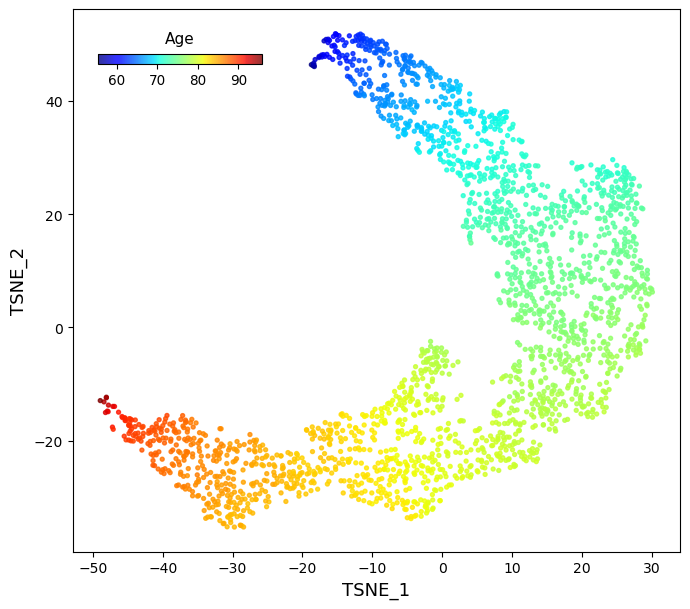

In [ ]:
plot_embedding(
    embeddings, color_by = extracted_dir['age'],
    figsize = (7, 6.2), s = 8, alpha = 0.8, cmap = 'jet', # (7, 6.2)
    fontsize = 13, ticksize = 10,
    show_legend = True, orientation = 'horizontal', shrink = 0.2, aspect = 20,
    legend_title = 'Age', legend_title_fontsize = 11, legend_ticks = [60, 70, 80, 90], legend_ticksize = 9.8,
)

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/TSNE_by_Age.png", dpi = 1000)

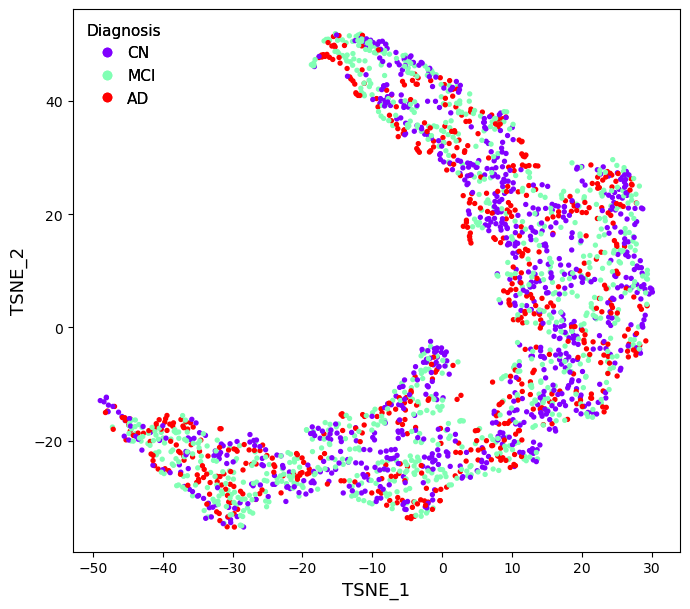

In [17]:
plot_embedding(
    embeddings, color_by = extracted_dir['dx_change'],
    figsize = (7, 6.2), s = 8, alpha = 1.0, cmap = 'rainbow',
    fontsize = 13, ticksize = 10,
    show_legend = True, legend_labels = ['CN', 'MCI', 'AD'], legend_frameon = False,
    legend_title = 'Diagnosis', legend_title_fontsize = 11, legend_fontsize = 11,
    legend_handlelength = 2.0, legend_handletextpad = 0.3, legend_loc = 'upper left',
)

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/TSNE_by_DX.png", dpi = 1000)

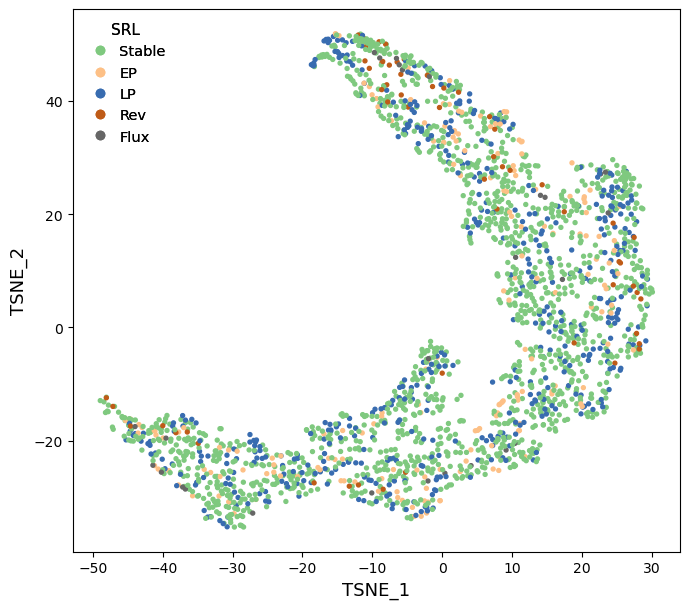

In [23]:
plot_embedding(
    embeddings, color_by = extracted_dir['SRL'],
    figsize = (7, 6.2), s = 8, alpha = 1.0, cmap = 'Accent',
    fontsize = 13, ticksize = 10,
    show_legend = True, legend_labels = ['Stable', 'EP', 'LP', 'Rev', 'Flux'], legend_frameon = False,
    legend_title = 'SRL', legend_title_fontsize = 11, legend_fontsize = 10.5,
    legend_handlelength = 2.0, legend_handletextpad = 0.3, legend_loc = 'upper left',
)

# set color_by = extracted_dir['SRL'], alpha = 1.0, cmap = 'Accent', legend_title = 'SRL',
# and legend_labels = ['Stable', 'EP', 'LP', 'Rev', 'Flux'] to get TSNE_by_SRL.png
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/TSNE_by_SRL.png", dpi = 1000)

# set color_by = extracted_dir['DRL'], alpha = 0.7, cmap = 'rainbow', legend_title = 'DRL',
# and legend_labels = ['sCN', 'sMCI', 'sAD', 'Early dCN', 'Early pMCI', 'Late dCN', 'Late pMCI', 'Rev', 'Flux'] to get TSNE_by_DRL.png
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/TSNE_by_DRL.png", dpi = 1000)

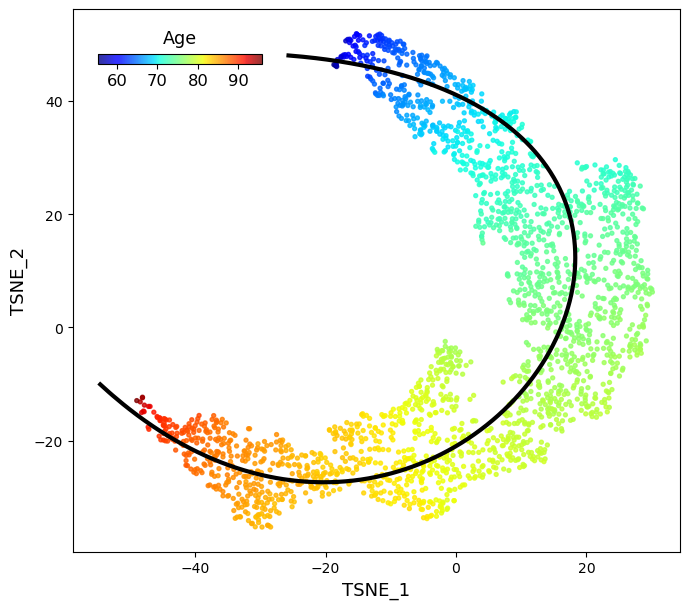

In [11]:
x = embeddings[np.argsort(extracted_dir['age'])]

## Two adjustable hyperparameters:
# bigger k : more coiled, smaller k : more extended (k = 3 recommended)
# bigger s : more generalized, smaller s : more strictly fitted (s >= 1e4 recommended)
curve = PrincipalCurve(k = 3, s = 1e5)
curve.fit(x, initial_points = None, max_iter = 10, tol = 1e-3)

# remove plt.figure(figsize = kwargs.get('figsize')) in plot_embedding function (compatibility issue)
plt.figure(figsize = (7, 6.2))
plt.plot(curve.points[:, 0], curve.points[:, 1], c = 'k', linewidth = 3.0, alpha = 1.0)
plot_embedding(
    embeddings, color_by = extracted_dir['age'],
    figsize = (7, 6.2), s = 8, alpha = 0.8, cmap = 'jet',
    fontsize = 13, ticksize = 10,
    show_legend = True, orientation = 'horizontal', shrink = 0.2, aspect = 20,
    legend_title = 'Age', legend_title_fontsize = 12.6, legend_ticks = [60, 70, 80, 90], legend_ticksize = 11.8,
)

## Get interpolation indices
# pseudotime_interp, point_interp, order = curve.unpack_params()

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/TSNE_by_Age_PC.png", dpi = 1000)

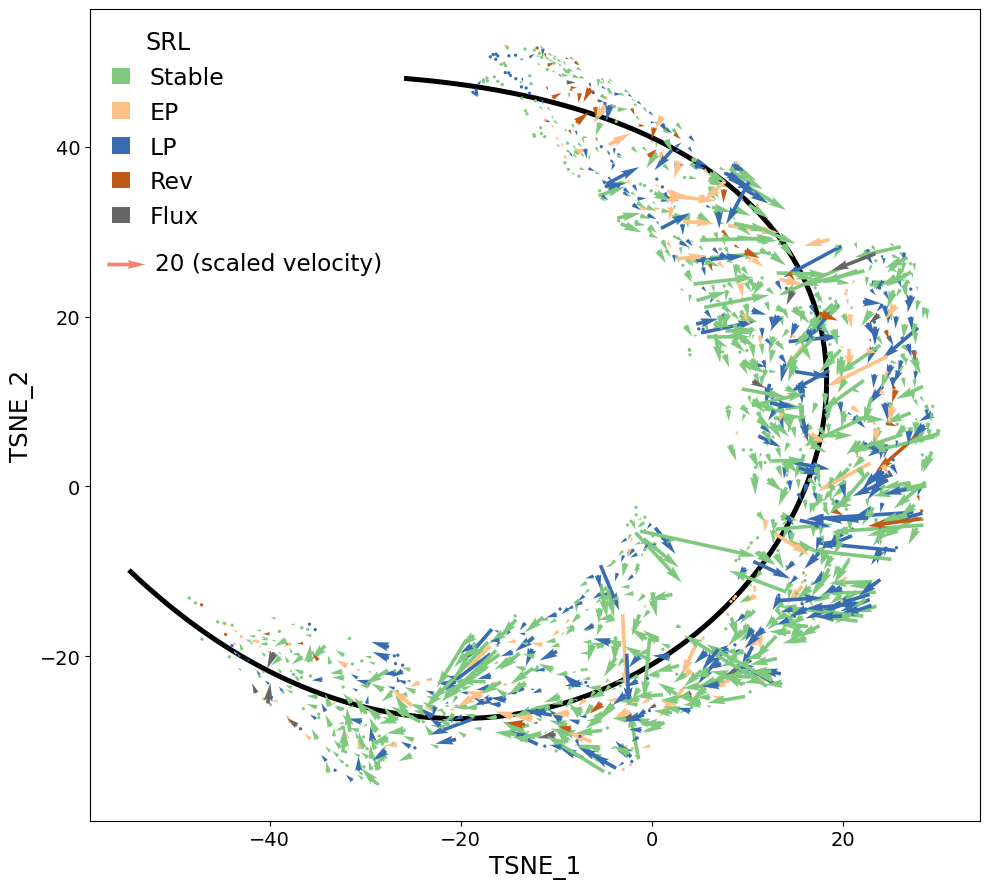

In [12]:
plt.figure(figsize = (10, 9))
plt.plot(curve.points[:, 0], curve.points[:, 1], c = 'k', linewidth = 3.6, alpha = 1.0, zorder = 1)
Q_per_subject = plot_flow_vector(
    embeddings, extracted_dir, plot_velocity = True, return_Q = True,
    alpha = 1.0, cmap = 'Accent', color_by = 'SRL',
    scale = 5, width = 0.4, headwidth = 2.5, headlength = 5.0,
    fontsize = 17.6, ticksize = 14,
    # label parameters
    show_legend = True, legend_labels = ['Stable', 'EP', 'LP', 'Rev', 'Flux'],
    legend_title = 'SRL', legend_title_fontsize = 17.2, legend_fontsize = 17,
    legend_handlelength = 0.8, legend_handletextpad = 0.8, legend_loc = 'upper left',
    # quiverkey parameters
    show_quiverkey = True, quiverkey_X = 0.15, quiverkey_Y = 0.7, quiverkey_U = 20,
    quiverkey_label = '20 (scaled velocity)', quiverkey_fontsize = 16.7, quiverkey_color = 'salmon', quiverkey_labelsep = 0.1,
)

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/START_by_SRL_PC.png", dpi = 1000)

In [13]:
xy_pairs, uv_pairs = [], []
for Q in Q_per_subject:
    qx, qy, qu, qv = Q.X, Q.Y, Q.U, Q.V
    xy_pairs.append(list(zip(*(qx, qy))))
    uv_pairs.append(list(zip(*(qu, qv))))

xy_pairs = np.array(sum(xy_pairs, []))
uv_pairs = np.array(sum(uv_pairs, []))

from scipy.spatial import cKDTree
segments = curve.points[1:] - curve.points[:-1]
unit_segments = segments / np.sqrt(np.square(segments).sum(1))[:, np.newaxis]

tree = cKDTree(curve.points[:-1])
_, indices = tree.query(xy_pairs, k = 1, p = 2)

Ts = np.array([unit_segments[idx] for idx in indices])
vecs_parallel = (uv_pairs * Ts).sum(1, keepdims = True) * Ts
vecs_perp = uv_pairs - vecs_parallel

inner_prod_parallel = (Ts * vecs_parallel).sum(1) # plus forward, minus backward
# cross_filter = ((indices <= 825) * -1.0 + (indices > 825) * 1.0)
cross_prod_perp = np.cross(Ts, vecs_perp) # plus outward, minus inward, but abs -> norm

In [14]:
import math
from scipy.spatial import cKDTree

segments = curve.points[1:] - curve.points[:-1]
unit_segments = segments / np.sqrt(np.square(segments).sum(1))[:, np.newaxis]

tree = cKDTree(curve.points[:-1])
_, indices = tree.query(xy_pairs, k = 1, p = 2)
Ts = np.array([unit_segments[idx] for idx in indices])

df = pd.DataFrame(
    {
        **{'PTID' : sum([[data['subject_id']] * data['age'].ne(0).sum() for data in dataset], [])},
        **dict(map(lambda k: (k, extracted_dir[k]), ['age_cond', 'age', 'dx_change_label', 'dx_change', 'DRL', 'SRL'])),
        **{'TSNE_1' : embeddings[:, 0], 'TSNE_2' : embeddings[:, 1]},
    }
)

df['age_cond'] = -np.log2(df['age_cond'])
df = df.sort_values(by = ['PTID', 'age']).reset_index(drop = True)

ptid_list, dist_list, velo_list, age_diff_list = [], [], [], []
dx_change_label_list, dx_change_list, drl_list, srl_list = [], [], [], []
avg_age_list, age_cond_diff_list = [], []

for ptid, sub_df in df.groupby('PTID'):
    temp_dist_list, temp_velo_list, temp_age_diff_list = [], [], []

    # calculate velocity info
    for i in range(len(sub_df) - 1):
        age_diff = np.array(sub_df.iloc[i+1]['age'] - sub_df.iloc[i]['age'])
        dist = np.array([sub_df.iloc[i+1]['TSNE_1'] - sub_df.iloc[i]['TSNE_1'], sub_df.iloc[i+1]['TSNE_2'] - sub_df.iloc[i]['TSNE_2']])
        velo = dist / age_diff
        temp_dist_list.append(dist)
        temp_velo_list.append(velo)
        temp_age_diff_list.append(age_diff)

    ptid_list.append(sub_df['PTID'][:-1].tolist())
    dist_list.append(temp_dist_list)
    velo_list.append(temp_velo_list)
    age_diff_list.append(temp_age_diff_list)
    
    dx_change_label_list.append(sub_df['dx_change_label'][:-1].tolist())

    temp = [str(int(sub_df.iloc[i]['dx_change'])) + '-' + str(int(sub_df.iloc[i+1]['dx_change'])) for i in range(len(sub_df) - 1)]
    encode = np.vectorize({'0-0': 0, '0-1': 1, '0-2': 2, '1-0': 3, '1-1': 4, '1-2': 5, '2-1': 6, '2-2': 7}.get)
    dx_change_list.append(encode(temp).tolist())

    drl_list.append(sub_df['DRL'][:-1].tolist())
    srl_list.append(sub_df['SRL'][:-1].tolist())
    
    avg_age_list.append([(sub_df.iloc[i]['age'] + sub_df.iloc[i+1]['age']) / 2 for i in range(len(sub_df) - 1)])
    age_cond_diff_list.append([(sub_df.iloc[i+1]['age_cond'] - sub_df.iloc[i]['age_cond']) for i in range(len(sub_df) - 1)])

ptid_list = sum(ptid_list, [])
dist_list = np.array(sum(dist_list, []))
velo_list = np.array(sum(velo_list, []))
age_diff_list = np.array(sum(age_diff_list, []))

dx_change_label_list = sum(dx_change_label_list, [])
dx_change_list = sum(dx_change_list, [])
drl_list = sum(drl_list, [])
srl_list = sum(srl_list, [])

avg_age_list = sum(avg_age_list, [])
age_cond_diff_list = sum(age_cond_diff_list, [])

para_dist_list = (Ts * dist_list).sum(1, keepdims = True) * Ts
perp_dist_list = dist_list - para_dist_list
para_velo_list = (Ts * velo_list).sum(1, keepdims = True) * Ts
perp_velo_list = velo_list - para_velo_list

df_per_move = pd.DataFrame(
    {
        'PTID' : ptid_list, 'avg_age' : avg_age_list, 'age_cond_diff' : age_cond_diff_list,
        'dist' : np.sqrt(np.square(dist_list).sum(1)),
        'para_dist' : (Ts * para_dist_list).sum(1),
        'perp_dist' : np.abs(np.cross(Ts, perp_dist_list)),
        'velo' : np.sqrt(np.square(velo_list).sum(1)),
        'para_velo' : (Ts * para_velo_list).sum(1),
        'perp_velo' : np.abs(np.cross(Ts, perp_velo_list)),
        'dx_change_label' : dx_change_label_list, 'dx_change' : dx_change_list,
        'DRL' : drl_list, 'SRL' : srl_list,
    }
)

tangent_to_degrees = lambda r: math.degrees(math.atan(r))
df_per_move['tan_angle'] = list(map(tangent_to_degrees, np.abs(df_per_move['perp_velo'] / df_per_move['para_velo'])))

df_per_idx = df_per_move.groupby('PTID').max()[
    ['dist', 'para_dist', 'perp_dist',
     'velo', 'para_velo', 'perp_velo',
     'tan_angle',
     'dx_change_label', 'DRL', 'SRL']
].reset_index()

df_per_idx['dx_change_label'] = df_per_idx['dx_change_label'].astype('int')
df_per_idx['DRL'] = df_per_idx['DRL'].astype('int')
df_per_idx['SRL'] = df_per_idx['SRL'].astype('int')
df_per_idx['move_num'] = np.unique(df_per_move['PTID'], return_counts = True)[1]


def assign_age_range(age, start = 60, end = 90, step = 10):
    last_i = int((end - start) / step) + 1
    for i in range(last_i):
        if age < start + i * step:
            return i
    return last_i

df['age_range'] = df['age'].apply(assign_age_range)
df_per_move['avg_age_range'] = df_per_move['avg_age'].apply(assign_age_range)

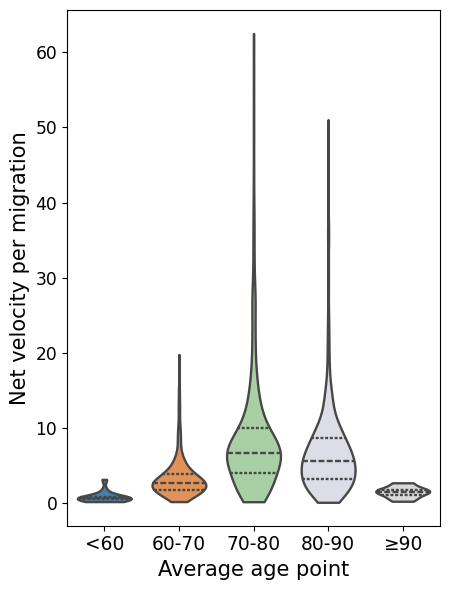

In [21]:
res = plot_and_test(
    subset_of_x = 'avg_age_range', compare_y = 'velo', split_by_hue = 'avg_age_range', df_tot = df_per_move,
    do_plot = True, do_test = False, figsize = (4.6, 6.0), inner = 'quart', cut = 0,
    order = list(range(5)), hue_order = list(range(5)),
    palette = sns.color_palette('tab20c', as_cmap = True), saturation = 0.7, width = 0.85, gap = 0.15, linewidth = 1.7,
    xlabel = 'Average age point', xticklabels = ['<60', '60-70', '70-80', '80-90', '\u226590'],
    ylabel = 'Net velocity per migration', fontsize = 15.1, xticks_fontsize = 13.4, yticks_fontsize = 12.3,
)

# use sns.violinplot in plot_and_test function with inner = 'quart' and cut = 0
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Net_velo_by_Age.png", dpi = 1000)

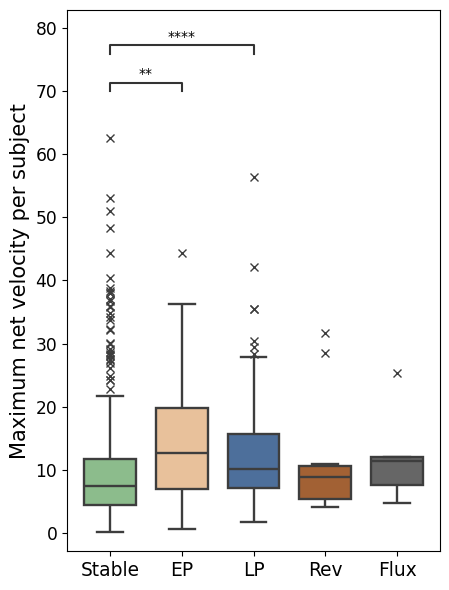

In [14]:
res = plot_and_test(
    subset_of_x = 'SRL', compare_y = 'velo', split_by_hue = 'SRL', df_tot = df_per_idx,
    do_plot = True, do_test = True, figsize = (4.6, 6.0), showfliers = True,
    order = list(range(5)), hue_order = list(range(5)),
    palette = sns.color_palette('Accent', as_cmap = True), saturation = 0.65, width = 0.85, gap = 0.15, linewidth = 1.7, fliersize = 5.3,
    xlabel = None, xticklabels = ['Stable', 'EP', 'LP', 'Rev', 'Flux'],
    ylabel = 'Maximum net velocity per subject', fontsize = 15.1, xticks_fontsize = 13.4, yticks_fontsize = 12.3,
    test = 'mann-whitney',
)

# compare_y = 'velo', ylabel = 'Maximum net velocity per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Net_velo_by_SRL.png", dpi = 1000)

# compare_y = 'para_velo', ylabel = 'Maximum parallel velocity per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Para_velo_by_SRL.png", dpi = 1000)

# compare_y = 'perp_velo', ylabel = 'Maximum perpendicular velocity per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Perp_velo_by_SRL.png", dpi = 1000)

# compare_y = 'tan_angle', ylabel = 'Maximum tangent angle per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Tan_angle_by_SRL.png", dpi = 1000)

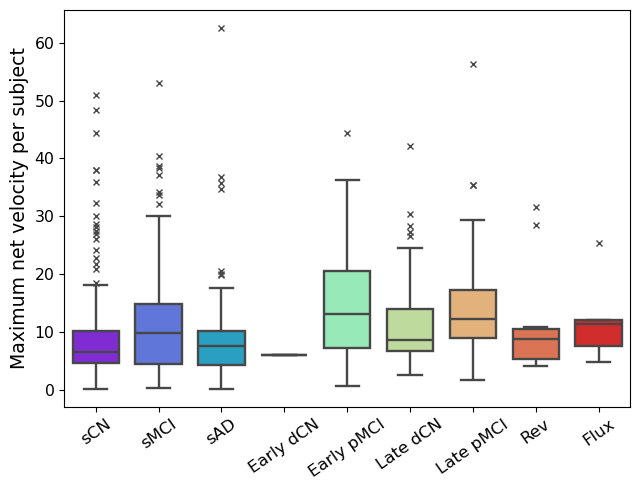

In [842]:
res = plot_and_test(
    subset_of_x = 'DRL', compare_y = 'velo', split_by_hue = 'DRL', df_tot = df_per_idx,
    do_plot = True, do_test = False, figsize = (6.5, 5), showfliers = True,
    order = list(range(9)), hue_order = list(range(9)),
    palette = sns.color_palette('rainbow', as_cmap = True), saturation = 0.65, width = 0.75, gap = 0.02, linewidth = 1.7, fliersize = 5,
    xlabel = None, xticklabels = ['sCN', 'sMCI', 'sAD', 'Early dCN', 'Early pMCI', 'Late dCN', 'Late pMCI', 'Rev', 'Flux'],
    xticks_rotation = 35, ylabel = 'Maximum net velocity per subject', fontsize = 13.6, xticks_fontsize = 12.0, yticks_fontsize = 11.3,
    test = 'mann-whitney',
)

# compare_y = 'velo', ylabel = 'Maximum net velocity per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Net_velo_by_DRL.png", dpi = 1000)

# compare_y = 'para_velo', ylabel = 'Maximum parallel velocity per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Para_velo_by_DRL.png", dpi = 1000)

# compare_y = 'perp_velo', ylabel = 'Maximum perpendicular velocity per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Perp_velo_by_DRL.png", dpi = 1000)

# compare_y = 'tan_angle', ylabel = 'Maximum tangent angle per subject'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Tan_angle_by_DRL.png", dpi = 1000)

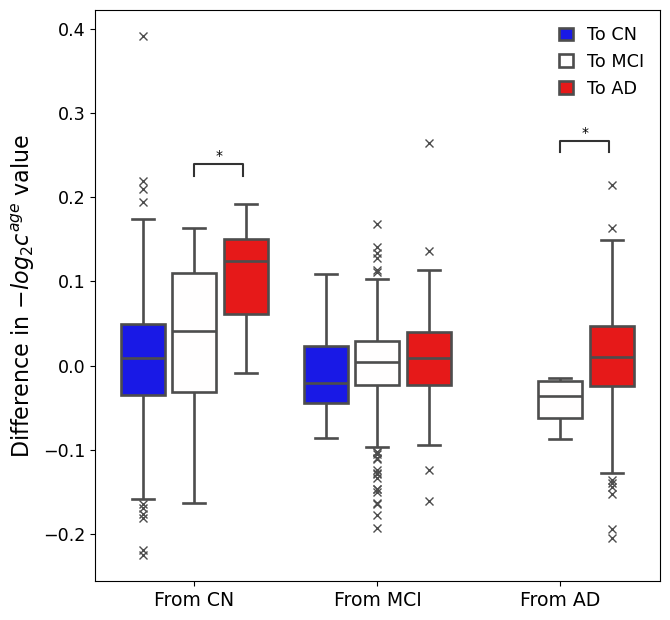

In [15]:
def regroup_by_dx_start(val):
    if val in [0, 1, 2]:
        return 0  # Starts from CN
    elif val in [3, 4, 5]:
        return 1  # Starts from MCI
    elif val in [6, 7]:
        return 2  # Starts from AD
    else:
        return np.nan

def regroup_by_dx_end(val):
    if val in [0, 3]:
        return 0  # Ends to CN
    elif val in [1, 4, 6]:
        return 1  # Ends to MCI
    elif val in [2, 5, 7]:
        return 2  # Ends to AD
    else:
        return np.nan

df_per_move['dx_change_start'] = df_per_move['dx_change'].apply(regroup_by_dx_start)
df_per_move['dx_change_end'] = df_per_move['dx_change'].apply(regroup_by_dx_end)

res = plot_and_test(
    subset_of_x = 'dx_change_start', compare_y = 'age_cond_diff', split_by_hue = 'dx_change_end', df_tot = df_per_move,
    do_plot = True, do_test = True, figsize = (6.8, 6.3), showfliers = True,
    order = list(range(3)), hue_order = list(range(3)),
    palette = sns.color_palette('bwr', as_cmap = True), saturation = 0.8, width = 0.85, gap = 0.15, linewidth = 1.9, fliersize = 5.1,
    xlabel = None, xticklabels = ['From CN', 'From MCI', 'From AD'],
    ylabel = r'Difference in $-log_2 c^{age}$ value', fontsize = 16, xticks_fontsize = 13.6, yticks_fontsize = 12.6,
    legend_labels = ['To CN', 'To MCI', 'To AD'], legend_fontsize = 12.7, legend_handlelength = 0.8, legend_handletextpad = 0.8,
    test = 'mann-whitney', line_offset = 5, line_offset_to_group = 0.05,
)

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Age_cond_diff_Detailed.png", dpi = 1000)

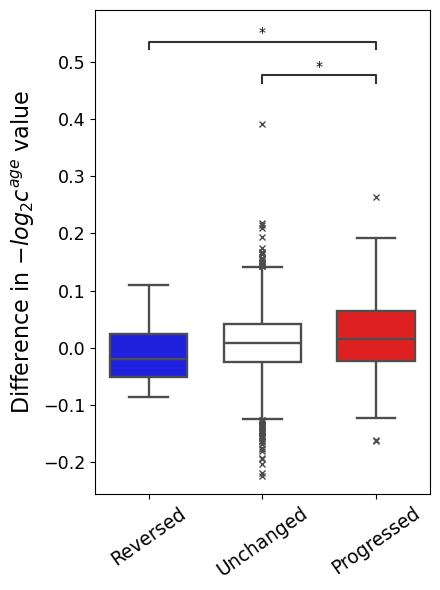

In [16]:
def regroup_by_dx_direction(val):
    if val in [3, 6]:
        return 0  # Reversed (toward CN)
    elif val in [0, 4, 7]:
        return 1  # Unchanged
    elif val in [1, 2, 5]:
        return 2  # Progressed (toward AD)
    else:
        return np.nan

df_per_move['dx_change_dir'] = df_per_move['dx_change'].apply(regroup_by_dx_direction)

res = plot_and_test(
    subset_of_x = 'dx_change_dir', compare_y = 'age_cond_diff', split_by_hue = 'dx_change_dir', df_tot = df_per_move,
    do_plot = True, do_test = True, figsize = (4.5, 6), showfliers = True,
    order = list(range(3)), hue_order = list(range(3)),
    palette = sns.color_palette('bwr', as_cmap = True), saturation = 0.75, fliersize = 4.8,
    xlabel = None, xticklabels = ['Reversed', 'Unchanged', 'Progressed'], xticks_rotation = 35,
    ylabel = r'Difference in $-log_2 c^{age}$ value', fontsize = 16, xticks_fontsize = 13.4, yticks_fontsize = 12.6,
    test = 'mann-whitney', line_offset = 5, line_offset_to_group = 0.1,
)

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Age_cond_diff_Simplified.png", dpi = 1000)

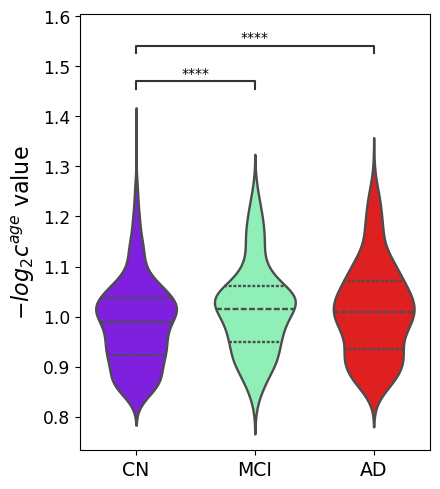

In [ ]:
res = plot_and_test(
    subset_of_x = 'dx_change', compare_y = 'age_cond', split_by_hue = 'dx_change', df_tot = df,
    do_plot = True, do_test = True, figsize = (4.5, 5), inner = 'quart', cut = 2,
    order = list(range(3)), hue_order = list(range(3)),
    palette = sns.color_palette('rainbow', as_cmap = True), saturation = 0.75,
    xlabel = None, xticklabels = ['CN', 'MCI', 'AD'],
    ylabel = r'$-log_2 c^{age}$ value', fontsize = 16, xticks_fontsize = 13.6, yticks_fontsize = 12.3,
    test = 'mann-whitney', line_offset = 5, line_offset_to_group = 0.55,
)

# use sns.violinplot in plot_and_test function with inner = 'quart' and cut = 2
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Age_cond_by_DX.png", dpi = 1000)

In [17]:
merged_df = pd.concat([df, amdata_df], axis = 1)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

diff_df = merged_df.groupby('PTID')[
    ['age_cond', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
     'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ']
].diff()
diff_df = diff_df[~diff_df.isna().all(1)].reset_index(drop = True)

merged_diff_df = pd.concat([df_per_move, diff_df], axis = 1)
merged_diff_df = merged_diff_df.loc[:, ~merged_diff_df.columns.duplicated()]
print(len(merged_diff_df))
del diff_df

1678


<Axes: >

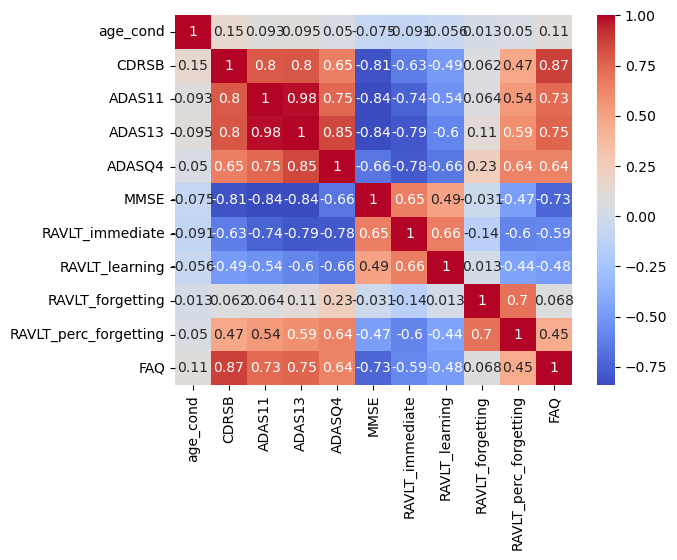

In [40]:
sns.heatmap(
    merged_df[
        ['age_cond', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
         'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ']
    ].corr(method = 'pearson'),
    annot = True,
    cmap = 'coolwarm',
)

In [ ]:
from scipy.stats import pearsonr

score_columns = [
    'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'FAQ',
    'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_perc_forgetting'
]

results = []

for score in score_columns:
    filtered_df = merged_df[~merged_df[score].isna()]
    r, p = pearsonr(filtered_df['age_cond'], filtered_df[score])
    n = len(filtered_df)
    results.append({'Clinical_exam': score, 'Included_N': n, 'Pearson_r': r, 'p_value': p})
    del filtered_df

df_pearson = pd.DataFrame(results)

# df_pearson.to_csv("/projects1/pi/hkjung/DDPM/figures/paper_figures/Age_cond_corr.csv", index = True)

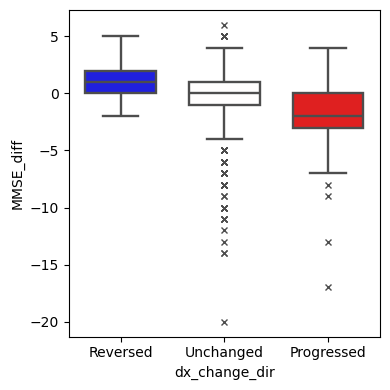

In [600]:
y = 'MMSE'
res = plot_and_test(subset_of_x = 'dx_change_dir', compare_y = y, split_by_hue = 'dx_change_dir', df_tot = merged_diff_df,
                    order = list(range(3)), hue_order = list(range(3)),
                    figsize = (4, 4), test = 'mann-whitney', do_test = True, showfliers = True,
                    palette = sns.color_palette('bwr', as_cmap = True), saturation = 0.75, fliersize = 4.0,
                    ylabel = y + '_diff', xticklabels = ['Reversed', 'Unchanged', 'Progressed'])

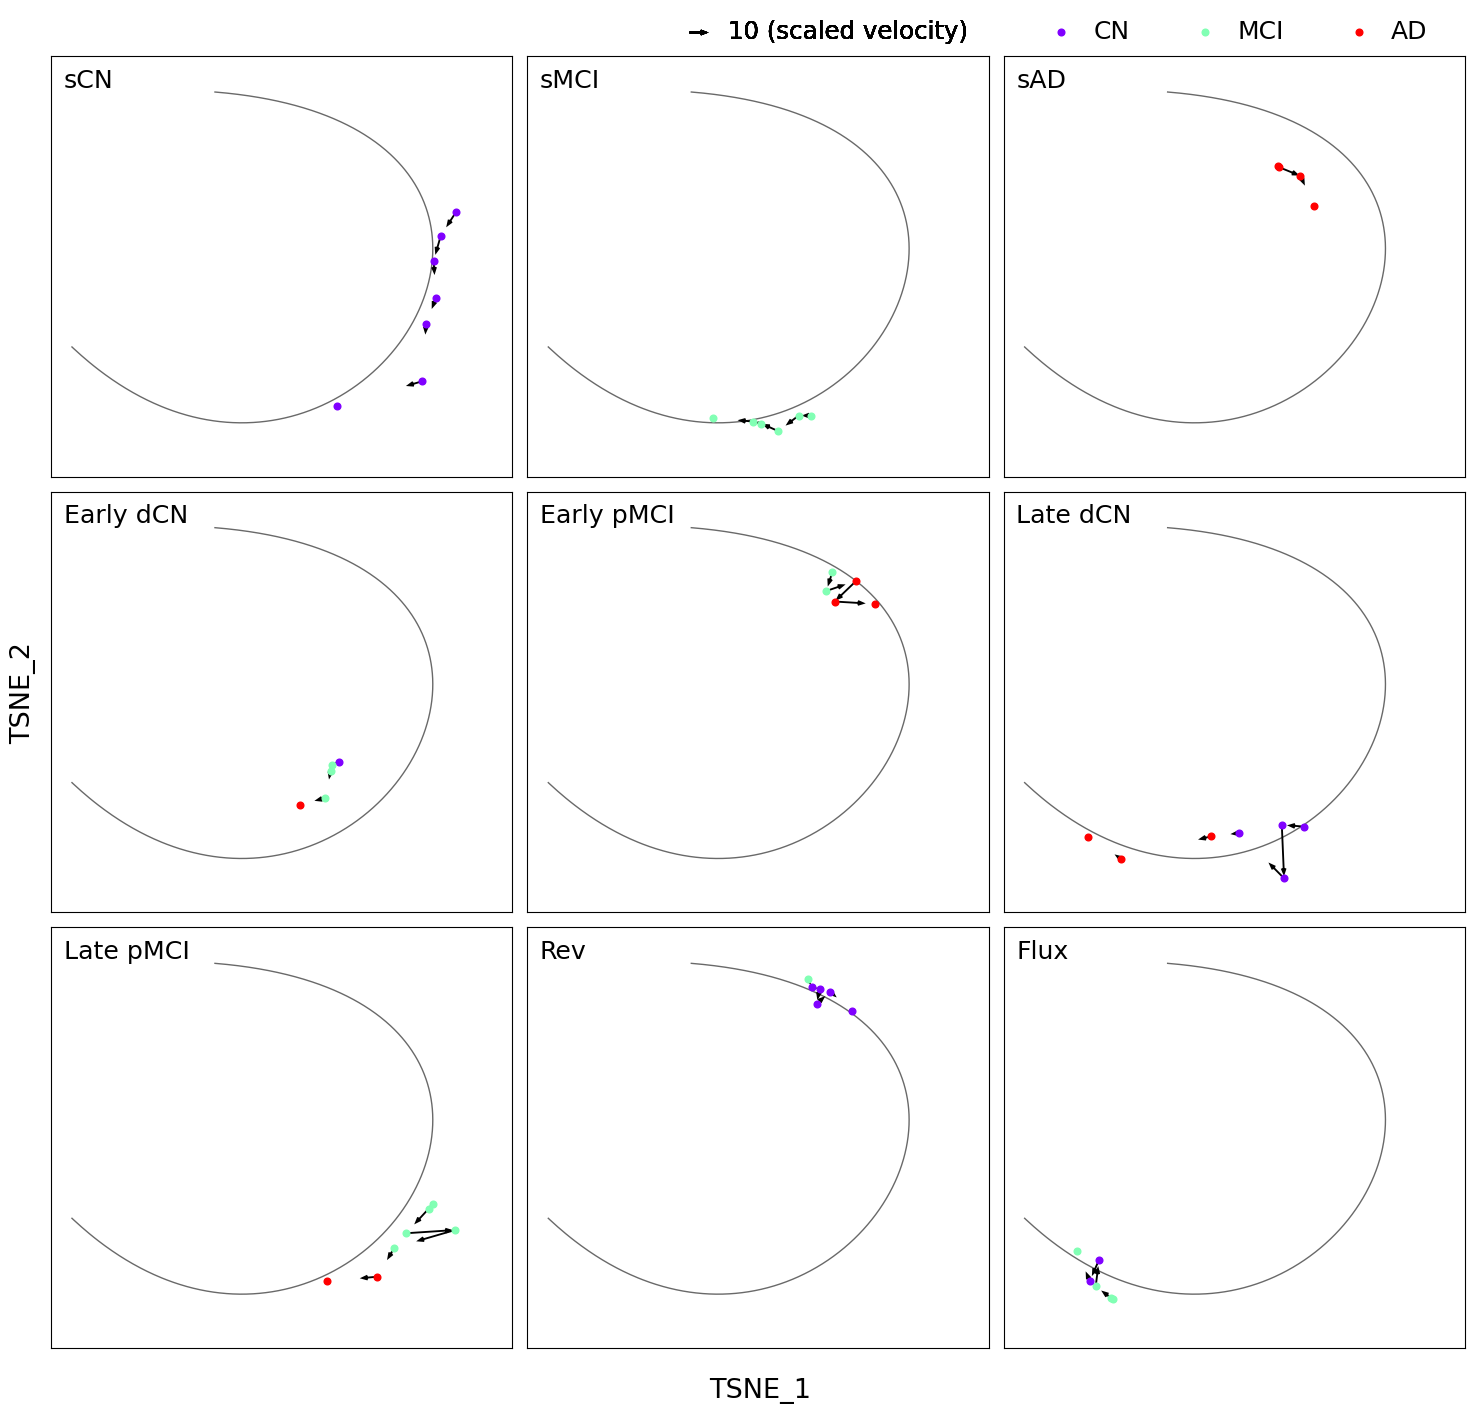

In [27]:
def plot_subject_trajectory(idx, extracted_dir = extracted_dir, embeddings = embeddings, curve = curve):

    bool_where = extracted_dir['idx'] == idx
    drl = ['sCN', 'sMCI', 'sAD', 'Early dCN', 'Early pMCI', 'Late dCN', 'Late pMCI', 'Rev', 'Flux'][extracted_dir['DRL'][bool_where][0]]

    plt.scatter(embeddings[:, 0], embeddings[:, 1], c = 'white', s = 6.0)
    plt.plot(curve.points[:, 0], curve.points[:, 1], c = 'dimgrey', linewidth = 1.0, alpha = 1.0, zorder = 1)

    Q = plot_subject_flow_vector(
        embeddings[bool_where], color = 'black', label = None, alpha = 1.0,
        plot_velocity = True, time_data = extracted_dir['age'][bool_where],
        scale = 2.6, width = 0.4, headwidth = 3, headlength = 4,
    )

    kv = plt.quiverkey(
        Q,
        X = 0.485,
        Y = 0.9562,
        U = 10,
        label = '10 (scaled velocity)',
        angle = 0, labelpos = 'E', coordinates = 'figure',
        color = 'black',
        labelcolor = 'black',
        labelsep = 0.2,
        fontproperties = {'size' : 17.6},
    )

    cmap = matplotlib.colormaps.get_cmap('rainbow')
    for i, dx in enumerate(extracted_dir['dx_change'][bool_where]):
        plt.scatter(
            embeddings[bool_where][i, 0], embeddings[bool_where][i, 1],
            color = cmap(dx / 2), s = 23, alpha = 1.0, label = ['CN', 'MCI', 'AD'][dx]
        )

    handles, labels = plt.gca().get_legend_handles_labels()
    hl = dict()
    for h, l in zip(handles, labels):
        if l not in hl:
            hl[l] = h

    h, l = hl.values(), hl.keys()

    plt.legend(
        [], [], title = drl,
        title_fontsize = 18.2,
        loc = 'upper left',
        frameon = False,
    )
    plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()
    return h, l


idx_list = [538, 158, 374, 26, 577, 486, 550, 483, 482]
fig = plt.figure(figsize = (15, 14.5))
nrows, ncols = 3, 3

handles, labels = [], []

for i, idx in enumerate(idx_list):
    fig.add_subplot(nrows, ncols, i + 1)
    h, l = plot_subject_trajectory(idx)
    handles.extend(h)
    labels.extend(l)

hl = dict()
for h, l in zip(handles, labels):
    if l not in hl:
        hl[l] = h

fig.legend(
    hl.values(), hl.keys(),
    loc = 'upper right', bbox_to_anchor = (0.98, 0.98),
    handlelength = 2.0, handletextpad = 0.3,
    fontsize = 18, frameon = False, ncol = 3,
)

fig.supxlabel('TSNE_1', fontsize = 19.5, x = 0.52); fig.supylabel('TSNE_2', fontsize = 19.5, y = 0.5)
plt.tight_layout(rect = [0.01, 0.01, 1.0, 0.95])

plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Trajectory_examples.png", dpi = 1000)

In [30]:
## Load stored samples of the validation set one by one and compare by various criteria (w, S, Model, SRL, DRL)

data_indices = np.arange(len(validation_set))
ptid = [validation_set[idx]['subject_id'] for idx in data_indices]
length = [validation_set[idx]['age'].ne(0).sum(0).item() for idx in data_indices]
sex = [validation_set[idx]['sex'].item() for idx in data_indices]

dx_last = [validation_set[idx]['dx_change'][-2] for idx in data_indices]
dx_pred = [validation_set[idx]['dx_change'][-1] for idx in data_indices]
drl = [validation_set[idx]['DRL'] for idx in data_indices]
srl = [validation_set[idx]['SRL'] for idx in data_indices]

age_itv = [np.diff(validation_set[idx]['age'])[length[i] - 2] for i, idx in enumerate(data_indices)]

## results comparison by fixed w and S

w_val, eta_val, S_val = 1.3, 0.0, 30
result0 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [w_val], [eta_val], [S_val]]
result1 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [w_val], [eta_val], [S_val]]
result2 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [w_val], [eta_val], [S_val]]
result3 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [w_val], [eta_val], [S_val]]
result4 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [w_val], [eta_val], [S_val]]


## results comparison by fixed w
"""
w_val = 1.5

result0 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [w_val], [0.0], [20]]
result1 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [w_val], [0.0], [30]]
result2 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [w_val], [0.0], [40]]
result3 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [w_val], [0.0], [50]]

result4 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [w_val], [0.0], [20]]
result5 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [w_val], [0.0], [30]]
result6 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [w_val], [0.0], [40]]
result7 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [w_val], [0.0], [50]]

result8 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [w_val], [0.0], [20]]
result9 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [w_val], [0.0], [30]]
result10 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [w_val], [0.0], [40]]
result11 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [w_val], [0.0], [50]]

result12 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [w_val], [0.0], [20]]
result13 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [w_val], [0.0], [30]]
result14 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [w_val], [0.0], [40]]
result15 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [w_val], [0.0], [50]]

result16 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [w_val], [0.0], [20]]
result17 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [w_val], [0.0], [30]]
result18 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [w_val], [0.0], [40]]
result19 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [w_val], [0.0], [50]]
"""

## results comparison by fixed S
"""
S_val = 50

result0 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [1.1], [0.0], [S_val]]
result1 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [1.2], [0.0], [S_val]]
result2 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [1.3], [0.0], [S_val]]
result3 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [1.4], [0.0], [S_val]]
result4 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [1.5], [0.0], [S_val]]

result5 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [1.1], [0.0], [S_val]]
result6 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [1.2], [0.0], [S_val]]
result7 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [1.3], [0.0], [S_val]]
result8 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [1.4], [0.0], [S_val]]
result9 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [1.5], [0.0], [S_val]]

result10 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [1.1], [0.0], [S_val]]
result11 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [1.2], [0.0], [S_val]]
result12 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [1.3], [0.0], [S_val]]
result13 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [1.4], [0.0], [S_val]]
result14 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [1.5], [0.0], [S_val]]

result15 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [1.1], [0.0], [S_val]]
result16 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [1.2], [0.0], [S_val]]
result17 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [1.3], [0.0], [S_val]]
result18 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [1.4], [0.0], [S_val]]
result19 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [1.5], [0.0], [S_val]]

result20 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [1.1], [0.0], [S_val]]
result21 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [1.2], [0.0], [S_val]]
result22 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [1.3], [0.0], [S_val]]
result23 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [1.4], [0.0], [S_val]]
result24 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [1.5], [0.0], [S_val]]
"""

results = [eval('result' + f'{i}') for i in range(5)]

sample_df = pd.DataFrame()

for result in results:
    sample_model, sample_info = result[0], result[1:]
    sample_df_temp = pd.DataFrame(
        index = data_indices,
        columns = [
            'PTID', 'Length', 'Sex', 'DX_last', 'DX_pred', 'DRL', 'SRL', 'Age_interval',
            'Model', 'w', 'eta', 'S', 'PSNR', 'SSIM', 'NRMSE'
            ]
        )
    for i, idx in enumerate(data_indices):
        sample_info[1] = idx
        _, psnr_value, ssim_value, nrmse_value = load_DDIM_sample(*sample_info).values()
        guide_w, eta, steps = sample_info[2:]
        sample_df_temp.iloc[i] = [
            alist[i] for alist in [ptid, length, sex, dx_last, dx_pred, drl, srl, age_itv]
            ] + [sample_model] + [
                alist[0] for alist in [guide_w, eta, steps, psnr_value, ssim_value, nrmse_value]
            ]
    sample_df = pd.concat((sample_df, sample_df_temp))
    del sample_df_temp

In [19]:
data_indices = np.arange(len(validation_set))

w_val, eta_val, S_val = 0.0, 0.0, 0
result0 = ['No-ViT-LastIE', 'STLAge_bs2_ga2_d(32)_e136', 0, [w_val], [eta_val], [S_val]]
result1 = ['ST-ViT-MeanTR', 'STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', 0, [w_val], [eta_val], [S_val]]
result2 = ['ST-ViT-MaxTR', 'STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', 0, [w_val], [eta_val], [S_val]]
result3 = ['STAge-ViT-MeanTR', 'STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', 0, [w_val], [eta_val], [S_val]]
result4 = ['STAge-ViT-MaxTR', 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', 0, [w_val], [eta_val], [S_val]]
results = [eval('result' + f'{i}') for i in range(5)]

sample_df = pd.DataFrame()

for result in results:
    sample_model, sample_info = result[0], result[1:]
    
    for w_val in [1.1, 1.2, 1.3, 1.4, 1.5]:
        sample_info[2] = [w_val]

        for S_val in [20, 30, 40, 50]:
            sample_info[4] = [S_val]

            sample_df_temp = pd.DataFrame(
                index = data_indices,
                columns = [
                    'Model', 'w', 'eta', 'S', 'PSNR', 'SSIM', 'NRMSE'
                    ]
                )
            for i, idx in enumerate(data_indices):
                sample_info[1] = idx
                _, psnr_value, ssim_value, nrmse_value = load_DDIM_sample(*sample_info).values()
                guide_w, eta, steps = sample_info[2:]
                sample_df_temp.iloc[i] = [sample_model] + [
                        alist[0] for alist in [guide_w, eta, steps, psnr_value, ssim_value, nrmse_value]
                    ]
            sample_df = pd.concat((sample_df, sample_df_temp))
            del sample_df_temp

In [ ]:
def IQR(x):
    return x.quantile(0.75) - x.quantile(0.25)

grouped = sample_df.groupby(['w', 'S', 'Model'])[['PSNR', 'SSIM', 'NRMSE']]
summary = grouped.agg(['median', IQR])
summary.columns = ['_'.join(col) for col in summary.columns]
summary = summary.reset_index()

for metric in ['PSNR', 'SSIM', 'NRMSE']:
    summary[metric + '_median'] = pd.to_numeric(summary[metric + '_median'], errors='coerce').round(4)
    summary[metric + '_IQR'] = summary[metric + '_IQR'].round(4)
    summary[metric] = summary[metric + '_median'].astype(str) + ' (' + summary[metric + '_IQR'].astype(str) + ')'
    summary.drop(columns = [metric + '_median', metric + '_IQR'], inplace = True)

summary = summary.pivot(index = ['w', 'S'], columns = 'Model', values = ['PSNR', 'SSIM', 'NRMSE'])
summary.columns = summary.columns.swaplevel(0, 1)
summary = summary.sort_index(axis = 1, level = [0, 1])

model_order = ['No-ViT-LastIE', 'ST-ViT-MeanTR', 'ST-ViT-MaxTR', 'STAge-ViT-MeanTR', 'STAge-ViT-MaxTR']
metric_order = ['PSNR', 'SSIM', 'NRMSE']

ordered_columns = pd.MultiIndex.from_tuples(
    [(model, metric) for model in model_order for metric in metric_order],
    names = ['Model', 'Metric']
)

summary = summary.reindex(columns = ordered_columns)

# summary.to_csv("/projects1/pi/hkjung/DDPM/figures/paper_figures/Model_validation_summary.csv", index = True)

In [ ]:
measure = 'PSNR'
res = plot_and_test(
    subset_of_x = 'w', compare_y = measure, split_by_hue = 'Model', df_tot = sample_df,
    do_plot = True, do_test = False, figsize = (27, 12), showfliers = True,
    width = 0.7, gap = 0.15, linewidth = 2.5, fliersize = 6.0,
    xlabel = r'$\it{w}$',
    fontsize = 13.0, legend_fontsize = 12.5, legend_loc = 'best',
    legend_handlelength = 1.2, legend_handletextpad = 0.6, legend_frameon = False,
    test = 'mann-whitney',
)

In [ ]:
measure = 'PSNR'
res = plot_and_test(
    subset_of_x = 'S', compare_y = measure, split_by_hue = 'Model', df_tot = sample_df,
    do_plot = True, do_test = False, figsize = (20, 12), showfliers = True,
    xlabel = r'Value of $\it{S}$',
    fontsize = 13.0, legend_fontsize = 12.5, legend_loc = 'best',
    legend_handlelength = 1.2, legend_handletextpad = 0.6, legend_frameon = False,
    test = 'mann-whitney',
)

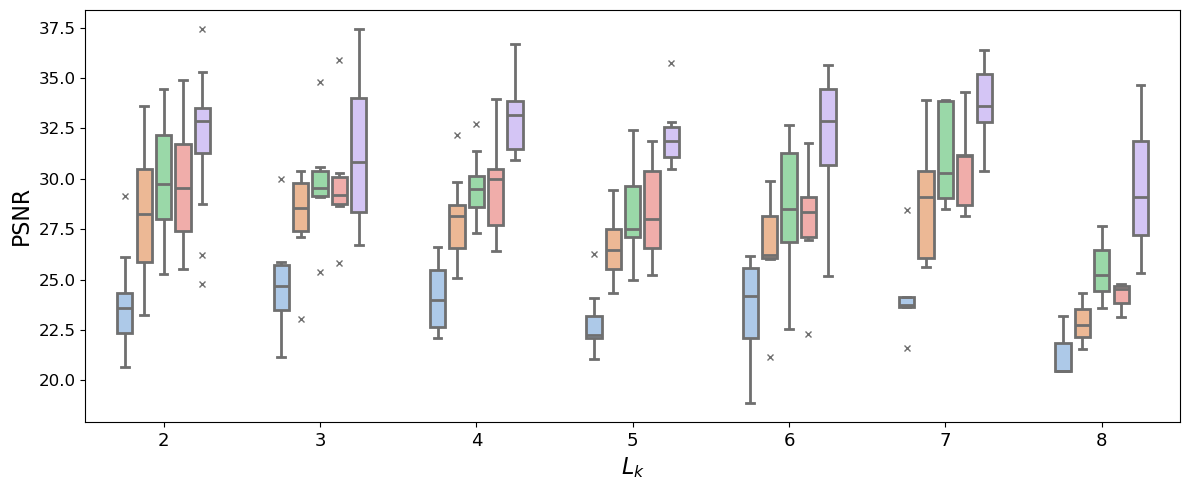

In [ ]:
measure = 'PSNR'
res = plot_and_test(
    subset_of_x = 'Length', compare_y = measure, split_by_hue = 'Model', df_tot = sample_df,
    do_plot = True, do_test = False, figsize = (12, 5), showfliers = True,
    width = 0.62, gap = 0.21, linewidth = 2.0, fliersize = 4.3,
    xlabel = r'$L_{k}$', ylabel = measure, show_legend = False,
    fontsize = 16.0, xticks_fontsize = 13, yticks_fontsize = 12, legend_fontsize = 9, legend_loc = 'best',
    legend_handlelength = 0.8, legend_handletextpad = 0.6, legend_frameon = False,
    test = 'mann-whitney',
)

# set measure = 'PSNR' or 'SSIM' or 'NRMSE'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/NRMSE_by_Lk_{w=1.3_S=30}.png", dpi = 1000)

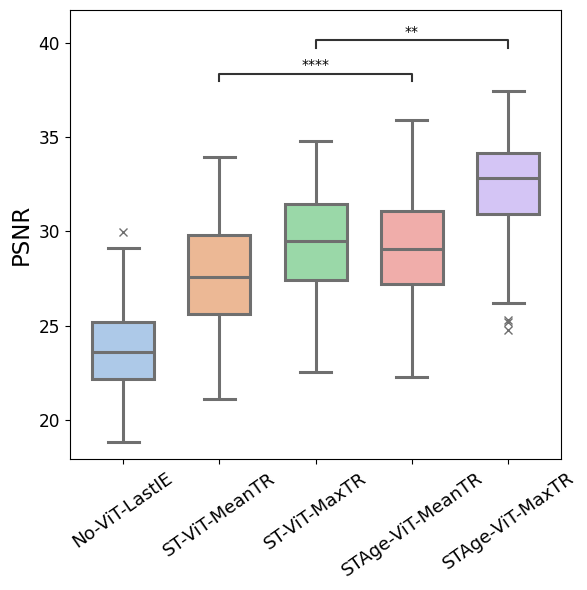

In [35]:
measure = 'PSNR'
res = plot_and_test(
    subset_of_x = 'Model', compare_y = measure, split_by_hue = 'Model', df_tot = sample_df,
    do_plot = True, do_test = True, figsize = (6, 6), showfliers = True,
    width = 0.65, gap = 0.01, linewidth = 2.2, fliersize = 5.3,
    xlabel = None, ylabel = measure, show_legend = False,
    fontsize = 16.5, xticks_fontsize = 13, xticks_rotation = 35, yticks_fontsize = 12.2, legend_fontsize = 9, legend_loc = 'best',
    legend_handlelength = 0.8, legend_handletextpad = 0.6, legend_frameon = False,
    test = 'mann-whitney',
    desired_pairs_list = [('ST-ViT-MeanTR', 'STAge-ViT-MeanTR'), ('ST-ViT-MaxTR', 'STAge-ViT-MaxTR')],
)

# set measure = 'PSNR' or 'SSIM' or 'NRMSE'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/NRMSE_by_Model_{w=1.3_S=30}.png", dpi = 1000)

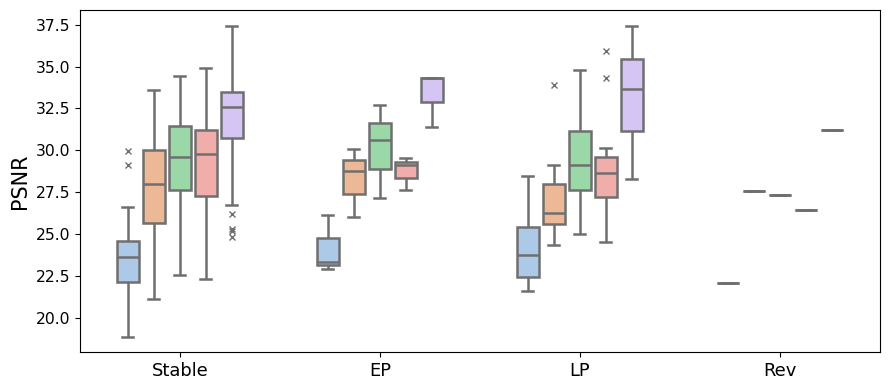

In [1000]:
measure = 'PSNR'
res = plot_and_test(
    subset_of_x = 'SRL', compare_y = measure, split_by_hue = 'Model', df_tot = sample_df,
    do_plot = True, do_test = False, figsize = (9, 4), showfliers = True,
    order = ['Stable', 'EP', 'LP', 'Reversal'],
    width = 0.65, gap = 0.15, linewidth = 1.8, fliersize = 5.0,
    xlabel = None, ylabel = measure, xticklabels = ['Stable', 'EP', 'LP', 'Rev'], show_legend = False,
    fontsize = 15.0, xticks_fontsize = 12.9, yticks_fontsize = 11.2, legend_fontsize = 9, legend_loc = 'best',
    legend_handlelength = 0.8, legend_handletextpad = 0.6, legend_frameon = False,
    test = 'mann-whitney',
    desired_pairs_list = [
        [('Stable', 'ST-ViT-MeanTR'), ('Stable', 'STAge-ViT-MeanTR')], [('Stable', 'ST-ViT-MaxTR'), ('Stable', 'STAge-ViT-MaxTR')],
        [('EP', 'ST-ViT-MeanTR'), ('EP', 'STAge-ViT-MeanTR')], [('EP', 'ST-ViT-MaxTR'), ('EP', 'STAge-ViT-MaxTR')],
        [('LP', 'ST-ViT-MeanTR'), ('LP', 'STAge-ViT-MeanTR')], [('LP', 'ST-ViT-MaxTR'), ('LP', 'STAge-ViT-MaxTR')],
        [('Reversal', 'ST-ViT-MeanTR'), ('Reversal', 'STAge-ViT-MeanTR')], [('Reversal', 'ST-ViT-MaxTR'), ('Reversal', 'STAge-ViT-MaxTR')],
    ]
)

# set measure = 'PSNR' or 'SSIM' or 'NRMSE'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/PSNR_by_SRL_{w=1.3_S=30}.png", dpi = 1000)

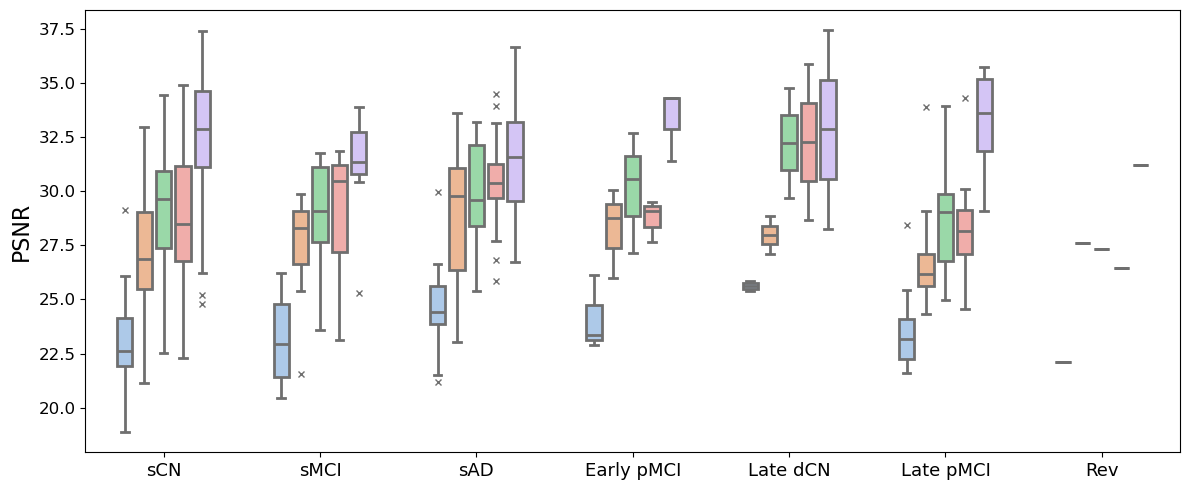

In [1008]:
measure = 'PSNR'
res = plot_and_test(
    subset_of_x = 'DRL', compare_y = measure, split_by_hue = 'Model', df_tot = sample_df,
    order = ['sCN', 'sMCI', 'sAD', 'Early pMCI', 'Late dCN', 'Late pMCI', 'Reversal'],
    do_plot = True, do_test = False, figsize = (12, 5), showfliers = True,
    width = 0.62, gap = 0.21, linewidth = 2.0, fliersize = 4.3,
    xlabel = None, ylabel = measure, xticklabels = ['sCN', 'sMCI', 'sAD', 'Early pMCI', 'Late dCN', 'Late pMCI', 'Rev'],
    show_legend = False,
    fontsize = 16.0, xticks_fontsize = 13, yticks_fontsize = 12, legend_fontsize = 9, legend_loc = 'best',
    legend_handlelength = 0.8, legend_handletextpad = 0.6, legend_frameon = False,
    test = 'mann-whitney',
)

# set measure = 'PSNR' or 'SSIM' or 'NRMSE'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/NRMSE_by_DRL_{w=1.3_S=30}.png", dpi = 1000)

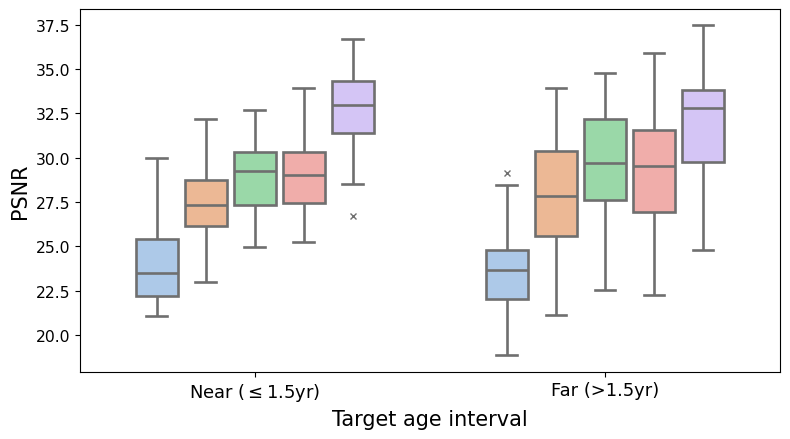

In [ ]:
assign_age_itv_range = lambda x: 'Far' if x > 1.5 else 'Near'
sample_df['Age_interval_range'] = sample_df['Age_interval'].apply(assign_age_itv_range)

measure = 'PSNR'
res = plot_and_test(
    subset_of_x = 'Age_interval_range', compare_y = measure, split_by_hue = 'Model', df_tot = sample_df,
    do_plot = True, do_test = False, figsize = (8, 4.5), showfliers = True,
    order = ['Near', 'Far'],
    width = 0.7, gap = 0.15, linewidth = 1.9, fliersize = 5.0,
    xlabel = 'Target age interval', ylabel = measure, xticklabels = [r'Near ($\leq$1.5yr)', 'Far (>1.5yr)'], show_legend = False,
    fontsize = 15.0, xticks_fontsize = 12.9, yticks_fontsize = 11.2, legend_fontsize = 9, legend_loc = 'best',
    legend_handlelength = 0.8, legend_handletextpad = 0.6, legend_frameon = False,
    test = 'mann-whitney',
    desired_pairs_list = [
        [('Near', 'ST-ViT-MeanTR'), ('Near', 'STAge-ViT-MeanTR')], [('Near', 'ST-ViT-MaxTR'), ('Near', 'STAge-ViT-MaxTR')],
        [('Far', 'ST-ViT-MeanTR'), ('Far', 'STAge-ViT-MeanTR')], [('Far', 'ST-ViT-MaxTR'), ('Far', 'STAge-ViT-MaxTR')],
    ]
)

# set measure = 'PSNR' or 'SSIM' or 'NRMSE'
# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/PSNR_by_Age_itv_{w=1.3_S=30}.png", dpi = 1000)

In [3]:
from nilearn.datasets import fetch_atlas_aal
atlas = fetch_atlas_aal(version = '3v2')

[get_dataset_dir] Dataset found in /home/hkjung/nilearn_data/aal_3v2

In [4]:
import nibabel as nib

img_path = "/home/hkjung/nilearn_data/aal_3v2/AAL3/AAL3v1.nii"
AAL_3v2_atlas_nifti = nib.load(img_path)
AAL_3v2_atlas_fdata = AAL_3v2_atlas_nifti.get_fdata().astype(np.int64) 

spacing, origin = get_img_info(AAL_3v2_atlas_nifti)
AAL_3v2_atlas_nifti = convert_to_sitk(AAL_3v2_atlas_nifti.get_fdata(), spacing, origin)
AAL_3v2_atlas_nifti = resample(AAL_3v2_atlas_nifti, (2.0, 2.0, 2.0), (96, 96, 96))
AAL_3v2_atlas = convert_to_numpy(AAL_3v2_atlas_nifti).astype(np.int64)

mni_template, mni_mask = get_mni152_template(), get_mni152_mask()
register_matrix = get_register_matrix(AAL_3v2_atlas, mni_template)

AAL_3v2_atlas = ants.from_numpy(AAL_3v2_atlas)
mni_template = ants.from_numpy(mni_template)
registered_AAL_3v2_atlas = ants.apply_transforms(
    fixed = mni_template,
    moving = AAL_3v2_atlas,
    transformlist = register_matrix,
    interpolator = 'nearestNeighbor'
)
registered_AAL_3v2_atlas = ants.core.ants_image.ANTsImage.numpy(registered_AAL_3v2_atlas)
registered_AAL_3v2_atlas = registered_AAL_3v2_atlas * mni_mask
registered_AAL_3v2_atlas = registered_AAL_3v2_atlas.astype(np.int64)

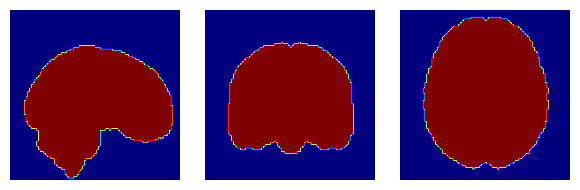

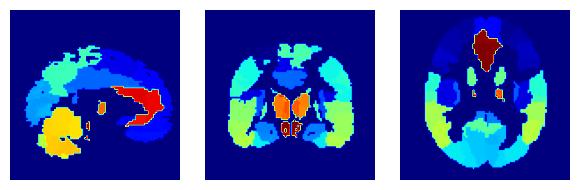

In [5]:
show_images(mni_mask)
show_images(registered_AAL_3v2_atlas)

In [6]:
label_map = dict(zip(list(map(int, atlas['indices'])), atlas['labels']))

target_regions = [
    # Angluar Gyrus
    'Angular_L', 'Angular_R',
    # Temporal Gyrus
    # 'Temporal_Sup_L', 'Temporal_Sup_R',
    # 'Temporal_Mid_L', 'Temporal_Mid_R',
    'Temporal_Inf_L', 'Temporal_Inf_R',
    # Posterior Cingulate
    'Cingulum_Post_L', 'Cingulum_Post_R'
]

vermis_regions = [
    'Vermis_1_2',
    'Vermis_3',
    'Vermis_4_5',
    'Vermis_6',
    'Vermis_7',
    'Vermis_8',
    'Vermis_9',
    'Vermis_10'
]

target_labels = [idx for idx, name in label_map.items() if name in target_regions]
vermis_labels = [idx for idx, name in label_map.items() if name in vermis_regions]

ROI_mask = np.isin(registered_AAL_3v2_atlas, target_labels)
vermis_mask = np.isin(registered_AAL_3v2_atlas, vermis_labels)

In [ ]:
# dataset = sum([train_set, validation_set], [])
# dataset.sort(key = lambda data: data['subject_id'])

load_model_name = 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114'
transformer = load_eval_models(load_model_name)['transformer']

mask_input = torch.tensor(get_mni152_mask()).to(device)
img_cond_list, suvr_list = [], []

for idx, data in tqdm(enumerate(dataset), total = len(dataset)):

    img_input = data['image'].unsqueeze(0).to(device)
    age_input = data['age'].unsqueeze(0).to(device)
    
    cond_output = transformer(img_input, age_input, mask_input, return_vector = False)
    img_cond = cond_output['img_cond'].cpu().detach()[0, 0]
    img_cond_list.append(img_cond)
    
    roi_mean = img_cond[ROI_mask].mean()
    vermis_mean = img_cond[vermis_mask].mean()
    suvr = (roi_mean / vermis_mean).item()
    suvr_list.append(suvr)

    del data, img_input, age_input, cond_output, img_cond

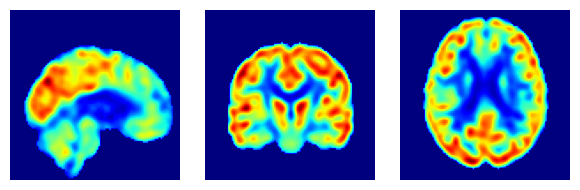

In [5]:
show_images(img_cond_list[0])

In [73]:
interpolated_validation_set = torch.load(f'/projects1/pi/hkjung/DDPM/data/interpolated_validation_set_v1.tar')

def make_sample_able_dataset(dataset: List) -> List:

    def truncate_data(data: dict) -> Tuple:
        frame_num = 9
        truncated_idx = max(0, len(data['age']) - frame_num)
        truncated_img_seq = image_padding(data['image'][truncated_idx:], frame_num)
        truncated_age_seq = age_padding(data['age'][truncated_idx:], frame_num)
        return {
            'subject_id' : data.get('subject_id'),
            'image' : truncated_img_seq,
            'age' : truncated_age_seq,
        }
    
    return list(map(truncate_data, dataset))

interpolated_validation_set = make_sample_able_dataset(interpolated_validation_set)
interpolated_validation_set.sort(key = lambda data: data['subject_id'])

mask_input = torch.tensor(get_mni152_mask()).to(device)
interpol_img_cond_list, interpol_suvr_list = [], []

for idx, data in tqdm(enumerate(interpolated_validation_set), total = len(interpolated_validation_set)):

    img_input = data['image'].unsqueeze(0).to(device)
    age_input = data['age'].unsqueeze(0).to(device)
    
    cond_output = transformer(img_input, age_input, mask_input, return_vector = False)
    interpol_img_cond = cond_output['img_cond'].cpu().detach()[0, 0]
    interpol_img_cond_list.append(interpol_img_cond)
    
    interpol_roi_mean = interpol_img_cond[ROI_mask].mean()
    interpol_vermis_mean = interpol_img_cond[vermis_mask].mean()
    interpol_suvr = (interpol_roi_mean / interpol_vermis_mean).item()
    interpol_suvr_list.append(interpol_suvr)

    del data, img_input, age_input, cond_output, interpol_img_cond

validation_set.sort(key = lambda data: data['subject_id'])
interpol_label_list = [data['dx_change_label'] for data in validation_set]

100%|██████████| 59/59 [00:08<00:00,  6.81it/s]


In [ ]:
drl_list = [data['DRL'] for data in dataset]
ptids = [data['subject_id'] for data in validation_set]
isin_val = [dataset[i]['subject_id'] in ptids for i in range(len(dataset))]

suvr_df = pd.DataFrame(
    {
        'SUVR' : np.array(suvr_list),
        'DRL' : np.vectorize({'sCN': 0, 'sMCI': 1, 'sAD': 2,
                              'Early dCN': 3, 'Early pMCI': 4, 'Late dCN': 5, 'Late pMCI': 6,
                              'Reversal': 7, 'Fluctuating': 8}.get)(drl_list),
        'SRL' : np.vectorize({'sCN': 0, 'sMCI': 0, 'sAD': 0,
                              'Early dCN': 1, 'Early pMCI': 1, 'Late dCN': 2, 'Late pMCI': 2,
                              'Reversal': 3, 'Fluctuating': 4}.get)(drl_list),
    }
)

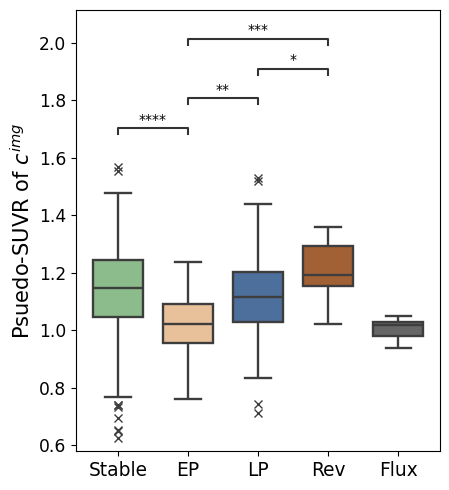

In [ ]:
res = plot_and_test(
    subset_of_x = 'SRL', compare_y = 'SUVR', split_by_hue = 'SRL', df_tot = suvr_df,
    do_plot = True, do_test = True, figsize = (4.6, 5.0), showfliers = True,
    order = list(range(5)), hue_order = list(range(5)),
    palette = sns.color_palette('Accent', as_cmap = True), saturation = 0.65, width = 0.85, gap = 0.15, linewidth = 1.7, fliersize = 5.3,
    xlabel = None, xticklabels = ['Stable', 'EP', 'LP', 'Rev', 'Flux'],
    ylabel = r'Psuedo-SUVR of $c^{img}$', fontsize = 15.1, xticks_fontsize = 13.4, yticks_fontsize = 12.3,
    test = 'mann-whitney', desired_pairs_list = [(0, 1), (1, 2), (1, 3), (2, 3)],
)

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Img_cond_pseudo_SUVR_by_SRL.png", dpi = 1000)

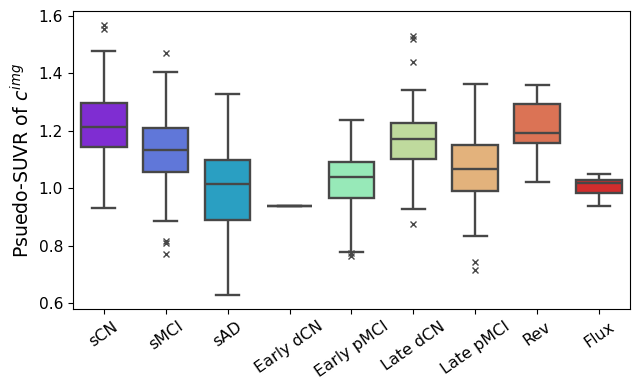

In [ ]:
res = plot_and_test(
    subset_of_x = 'DRL', compare_y = 'SUVR', split_by_hue = 'DRL', df_tot = suvr_df,
    do_plot = True, do_test = False, figsize = (6.5, 4), showfliers = True,
    order = list(range(9)), hue_order = list(range(9)),
    palette = sns.color_palette('rainbow', as_cmap = True), saturation = 0.65, width = 0.75, gap = 0.02, linewidth = 1.7, fliersize = 5,
    xlabel = None, xticklabels = ['sCN', 'sMCI', 'sAD', 'Early dCN', 'Early pMCI', 'Late dCN', 'Late pMCI', 'Rev', 'Flux'],
    xticks_rotation = 35, ylabel = r'Psuedo-SUVR of $c^{img}$', fontsize = 13.6, xticks_fontsize = 11.5, yticks_fontsize = 11.1,
    test = 'mann-whitney',
)

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Img_cond_pseudo_SUVR_by_DRL.png", dpi = 1000)

In [11]:
interpolated_validation_set = torch.load(f'/projects1/pi/hkjung/DDPM/data/interpolated_validation_set_v1_all.tar')

load_model_name = 'STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114'
transformer = load_eval_models(load_model_name)['transformer']

mask_input = torch.tensor(get_mni152_mask()).to(device)

def compute_suvr(img, roi_mask, refer_mask):
    return (img[roi_mask].mean() / img[refer_mask].mean()).item()

real_suvrs, sample_suvrs = [], []
real_age_conds, sample_age_conds = [], []
dxs = []

for i in range(len(interpolated_validation_set)):

    length = validation_set[i]['age'].ne(0).sum(0).item()
    real_data = validation_set[i]
    sample_data = interpolated_validation_set[i]

    for j in range(1, length):

        real_img, real_age = real_data['image'][j], real_data['age'][j]
        tgt_idx = (sample_data['age'] == real_age).nonzero().item()
        sample_img = sample_data['image'][tgt_idx]

        real_suvr = compute_suvr(real_img, ROI_mask, vermis_mask)
        sample_suvr = compute_suvr(sample_img, ROI_mask, vermis_mask)

        real_img = image_padding(real_img.unsqueeze(0)).unsqueeze(0).to(device)
        sample_img = image_padding(sample_img.unsqueeze(0)).unsqueeze(0).to(device)
        real_age = age_padding(real_age.unsqueeze(0)).unsqueeze(0).to(device)

        real_cond_output = transformer(real_img, real_age, mask_input, return_vector = True)
        sample_cond_output = transformer(sample_img, real_age, mask_input, return_vector = True)
        real_age_cond = real_cond_output['age_cond'].cpu().detach().item()
        sample_age_cond = sample_cond_output['age_cond'].cpu().detach().item()

        dx = real_data['dx_change'][j]

        real_suvrs.append(real_suvr)
        sample_suvrs.append(sample_suvr)
        real_age_conds.append(real_age_cond)
        sample_age_conds.append(sample_age_cond)
        dxs.append(dx)

        del real_suvr, sample_suvr, real_cond_output, sample_cond_output, dx

0.7147960711382129 0.6237303386777382 1.0423640745805486e-37


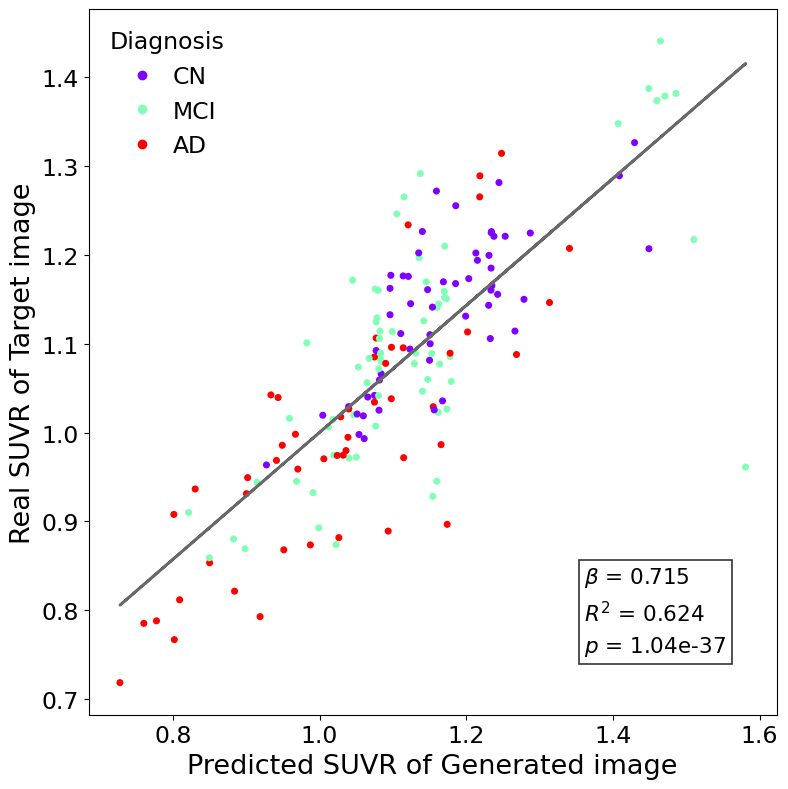

In [29]:
import statsmodels.api as sm

dx_map = np.vectorize({'CN' : 0, 'MCI' : 1, 'AD' : 2}.get)
model = sm.OLS(real_suvrs, sm.add_constant(sample_suvrs))
results = model.fit()

beta_0, beta_1 = results.params
r_squared = results.rsquared
p_values = results.pvalues

print(beta_1, r_squared, p_values[1])

plt.figure(figsize = (8, 8))
scatter = plt.scatter(sample_suvrs, real_suvrs, s = 16.5, c = dx_map(dxs), cmap = 'rainbow')
plt.plot(sample_suvrs, beta_0 + beta_1 * np.array(sample_suvrs), color = 'dimgrey', alpha = 1.0, linewidth = 2.0)
handles, labels = scatter.legend_elements()
plt.legend(
    handles, ['CN', 'MCI', 'AD'],
    title = 'Diagnosis', title_fontsize = 17, fontsize = 16.9, frameon = False,
    handlelength = 2.0, handletextpad = 0.3, loc = 'upper left'
)

textstr = "$\\beta$ = {:.3f}\n$R^2$ = {:.3f}\n$p$ = {:.3g}".format(beta_1, r_squared, p_values[1])

plt.gca().text(
    0.72, 0.08, textstr, transform = plt.gca().transAxes,
    fontsize = 15.5, va = 'bottom', ha = 'left', linespacing = 1.5,
    bbox = dict(facecolor = 'white', edgecolor = 'black', alpha = 0.8, linewidth = 1.2),
)

plt.xlabel('Predicted SUVR of Generated image', fontsize = 19.5)
plt.ylabel('Real SUVR of Target image', fontsize = 19.5)
plt.xticks(fontsize = 17); plt.yticks(fontsize = 17)
plt.tight_layout()

plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/SUVR_pred_by_interpolation.png", dpi = 1000)

0.9299526076549063 0.929090193400479 4.873198784289751e-99


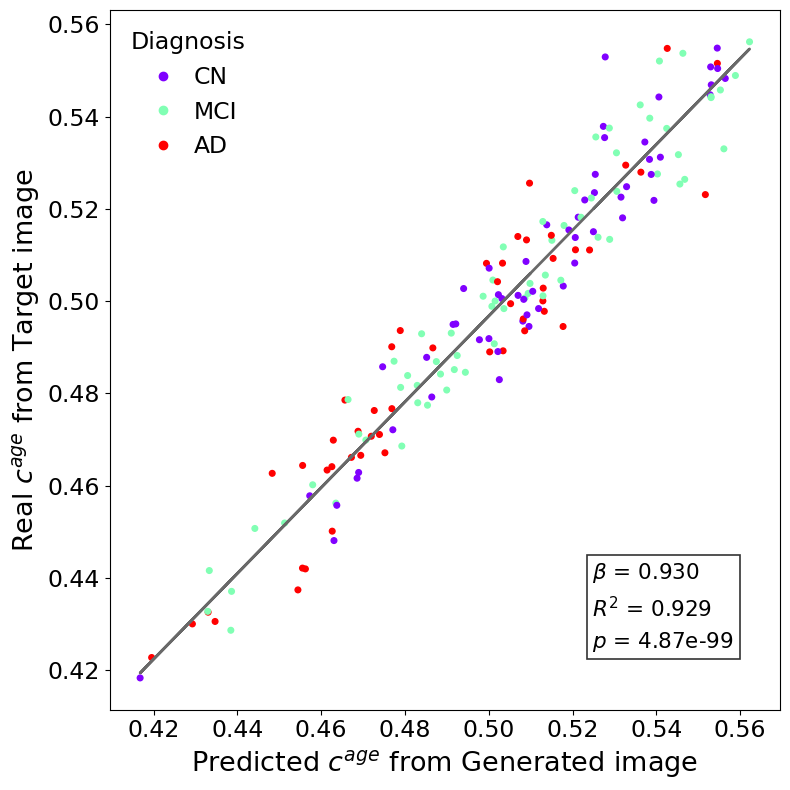

In [ ]:
import statsmodels.api as sm

dx_map = np.vectorize({'CN' : 0, 'MCI' : 1, 'AD' : 2}.get)
model = sm.OLS(real_age_conds, sm.add_constant(sample_age_conds))
results = model.fit()

beta_0, beta_1 = results.params
r_squared = results.rsquared
p_values = results.pvalues

print(beta_1, r_squared, p_values[1])

plt.figure(figsize = (8, 8))
scatter = plt.scatter(sample_age_conds, real_age_conds, s = 16.5, c = dx_map(dxs), cmap = 'rainbow')
plt.plot(sample_age_conds, beta_0 + beta_1 * np.array(sample_age_conds), color = 'dimgrey', alpha = 1.0, linewidth = 2.0)
handles, labels = scatter.legend_elements()
plt.legend(
    handles, ['CN', 'MCI', 'AD'],
    title = 'Diagnosis', title_fontsize = 17, fontsize = 16.9, frameon = False,
    handlelength = 2.0, handletextpad = 0.3, loc = 'upper left'
)

textstr = "$\\beta$ = {:.3f}\n$R^2$ = {:.3f}\n$p$ = {:.3g}".format(beta_1, r_squared, p_values[1])

plt.gca().text(
    0.72, 0.08, textstr, transform = plt.gca().transAxes,
    fontsize = 15.5, va = 'bottom', ha = 'left', linespacing = 1.5,
    bbox = dict(facecolor = 'white', edgecolor = 'black', alpha = 0.8, linewidth = 1.2),
)

plt.xlabel(r'Predicted $c^{age}$ from Generated image', fontsize = 19.5)
plt.ylabel(r'Real $c^{age}$ from Target image', fontsize = 19.5)
plt.xticks(fontsize = 17); plt.yticks(fontsize = 17)
plt.tight_layout()

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/Age_cond_pred_by_interpolation.png", dpi = 1000)

In [ ]:
for i in range(2):
    show_images(dataset[0]['image'][i], figsize = (9, 3))
    # plt.savefig(f"/projects1/pi/hkjung/DDPM/figures/paper_figures/Subject_0_img{i}.png", dpi = 1000)
show_images(img_cond_list[0], figsize = (9, 3))
# plt.savefig(f"/projects1/pi/hkjung/DDPM/figures/paper_figures/Subject_0_img_cond.png", dpi = 1000)

In [ ]:
for i in range(5):
    if i in (0, 3, 4):
        show_images(dataset[400]['image'][i], figsize = (9, 3))
        # plt.savefig(f"/projects1/pi/hkjung/DDPM/figures/paper_figures/Subject_400_img{i}.png", dpi = 1000)

In [25]:
import nibabel as nib
from nilearn import plotting

def re_register_img_to_mni_space(img, output_file = None, show_mid_slices = True, **kwargs):

    if type(img) == torch.Tensor:
        img = img.numpy()
    else:
        assert type(img) == np.ndarray
    
    mni_template = load_mni152_template(resolution = 1.0)
    mni_mask = load_mni152_brain_mask(resolution = 1.0, threshold = 0.2)
    spacing, origin = get_img_info(mni_template)
    affine = mni_template.affine

    brain_img = nib.Nifti1Image(img, affine)
    spacing, origin = get_img_info(brain_img)
    brain_img = convert_to_sitk(brain_img.get_fdata(), spacing, origin)
    brain_img = resample(brain_img, (1.0, 1.0, 1.0), (197, 233, 189))
    brain_img = convert_to_numpy(brain_img)

    register_matrix = get_register_matrix(brain_img, mni_template.get_fdata())
    registered_pet_img = register_pet_to_template(brain_img, mni_template.get_fdata(), register_matrix, mni_mask.get_fdata())
    brain_img = nib.Nifti1Image(registered_pet_img, affine)

    if show_mid_slices:
        show_images(registered_pet_img)

    plotting.plot_glass_brain(brain_img, **kwargs)
    if output_file:
        plt.savefig(output_file, dpi = 1000)
    
    plotting.show()

In [60]:
idx = 28
length = validation_set[idx]['age'].ne(0).sum(0).item()
tgt_img = validation_set[idx]['image'][length - 1].numpy()

w_val, eta_val, S_val = 1.3, 0.0, 30

NoViT_LastIE = ['STLAge_bs2_ga2_d(32)_e136', idx, [w_val], [eta_val], [S_val]]
STViT_MeanTR = ['STNAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e146', idx, [w_val], [eta_val], [S_val]]
STViT_MaxTR = ['STNAge_v1_bs2_ga2_ps6_max_d(108_11_32)_FF_e126', idx, [w_val], [eta_val], [S_val]]
STAgeViT_MeanTR = ['STAge_v1_bs2_ga2_ps6_mean_ndiff_d(108_11_32)_FF_e142', idx, [w_val], [eta_val], [S_val]]
STAgeViT_MaxTR = ['STAge_v1_bs2_ga2_ps6_max_ndiff_d(108_11_32)_FF_e114', idx, [w_val], [eta_val], [S_val]]

def fetch_sample_and_metrics(sample_info, print_metrics = True):
    sample_img, psnr_val, ssim_val, nrmse_val = load_DDIM_sample(*sample_info).values()
    sample_img = sample_img[0]
    if print_metrics:
        print(f'PSNR: {psnr_val[0]:.4f}, SSIM: {ssim_val[0]:.4f}, NRMSE: {nrmse_val[0]:.4f}')
    return sample_img

print(length, validation_set[idx]['dx_change'], validation_set[idx]['sex'].item())

3 ['CN', 'CN', 'MCI'] 0


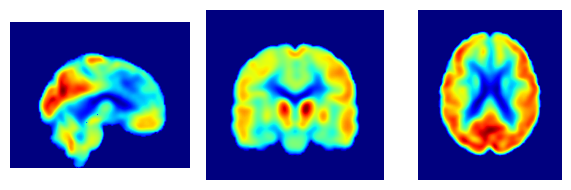

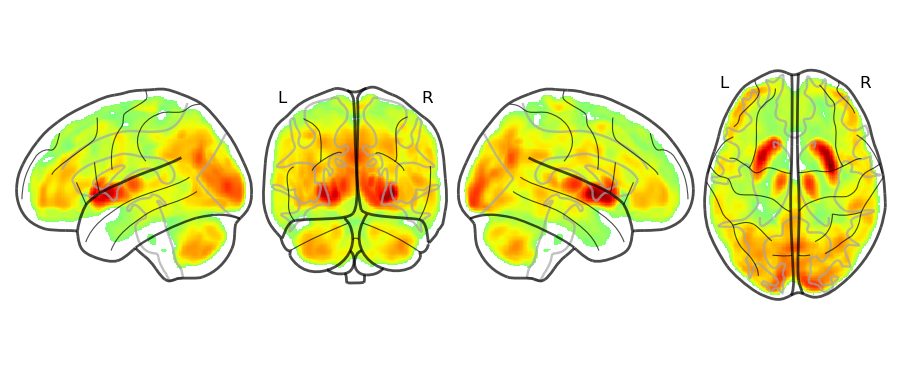

In [ ]:
re_register_img_to_mni_space(
    tgt_img, show_mid_slices = True,
    display_mode = 'lyrz', threshold = 0.5, cmap = 'jet',
    # output_file = "/projects1/pi/hkjung/DDPM/figures/paper_figures/Sample_44_Target.png",  # change here if saving the file
)

PSNR: 37.4488, SSIM: 0.9894, NRMSE: 0.0134


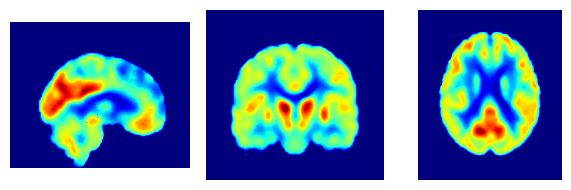

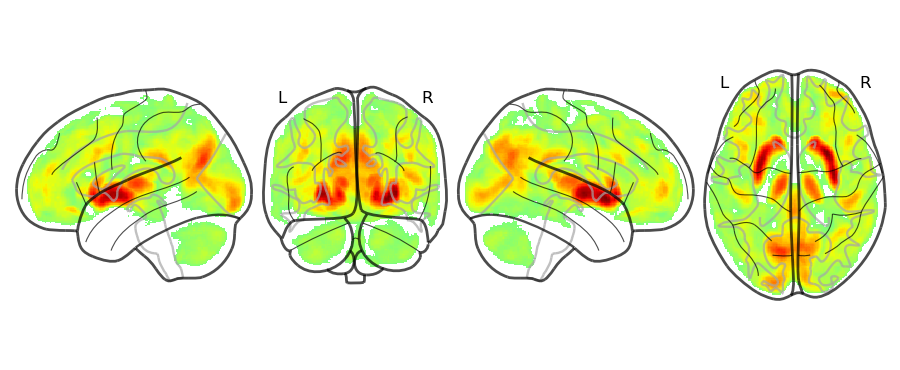

In [61]:
sample_info = STAgeViT_MaxTR  # change here
re_register_img_to_mni_space(
    fetch_sample_and_metrics(sample_info), show_mid_slices = True,
    display_mode = 'lyrz', threshold = 0.5, cmap = 'jet',
    # output_file = "/projects1/pi/hkjung/DDPM/figures/paper_figures/Sample_28_STAgeViT_MaxTR.png",  # and here if saving the file
)

## Sample_28 (Lk = 3, dx_change = ['CN', 'CN', 'MCI'], sex = 'Male')
# STAgeViT_MaxTR - PSNR: 37.4488, SSIM: 0.9894, NRMSE: 0.0134
# STAgeViT_MeanTR - PSNR: 35.9027, SSIM: 0.9893, NRMSE: 0.0160
# STViT_MaxTR - PSNR: 34.7855, SSIM: 0.9882, NRMSE: 0.0182
# STViT_MeanTR - PSNR: 27.1052, SSIM: 0.9743, NRMSE: 0.0441
# NoViT_LastIE - PSNR: 25.8603, SSIM: 0.9680, NRMSE: 0.0509

PSNR: 33.1757, SSIM: 0.9849, NRMSE: 0.0219


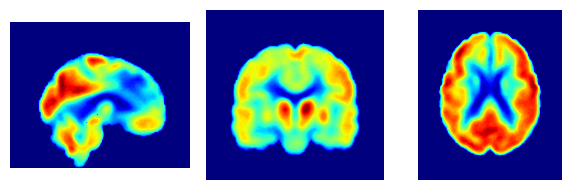

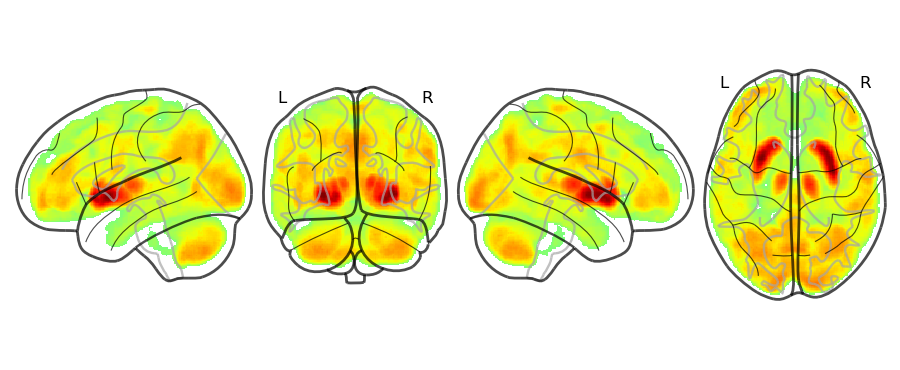

In [58]:
sample_info = STAgeViT_MaxTR  # change here
re_register_img_to_mni_space(
    fetch_sample_and_metrics(sample_info), show_mid_slices = True,
    display_mode = 'lyrz', threshold = 0.5, cmap = 'jet',
    # output_file = "/projects1/pi/hkjung/DDPM/figures/paper_figures/Sample_44_STAgeViT_MaxTR.png",  # and here if saving the file
)

## Sample_44 (Lk = 4, dx_change = ['MCI', 'MCI', 'MCI', 'AD'], sex = 'Female')
# STAgeViT_MaxTR - PSNR: 33.1757, SSIM: 0.9849, NRMSE: 0.0219
# STAgeViT_MeanTR - PSNR: 27.3066, SSIM: 0.9756, NRMSE: 0.0431
# STViT_MaxTR - PSNR: 29.1433, SSIM: 0.9810, NRMSE: 0.0349
# STViT_MeanTR - PSNR: 25.0817, SSIM: 0.9676, NRMSE: 0.0557
# NoViT_LastIE - PSNR: 22.5864, SSIM: 0.9450, NRMSE: 0.0742

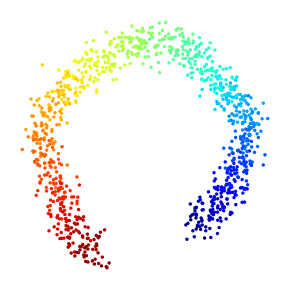

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_cells = 1000

angles = np.linspace(-np.pi / 3, 4 * np.pi / 3, n_cells)

base_radius = 5 + 1.5 * np.sin(angles / 2)
irregularity = 0.3 * np.sin(5 * angles) + 0.2 * np.random.randn(n_cells)
radius = base_radius + irregularity

x = radius * np.cos(angles) + 0.5 * np.random.randn(n_cells)
y = radius * np.sin(angles) + 0.5 * np.random.randn(n_cells)

pseudotime = np.linspace(0, 1, n_cells)

plt.figure(figsize = (3, 3))
plt.scatter(x, y, c = pseudotime, cmap = 'jet', s = 6, edgecolors = 'none')
plt.axis('off')
plt.tight_layout()

# plt.savefig("/projects1/pi/hkjung/DDPM/figures/paper_figures/TSNE_like_image.png", dpi = 1000)